In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)

import matplotlib.pyplot as plt
import gc
import re

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

BES_data_folder = "../BES_analysis_data/"
BES_code_folder = "../BES_analysis_code/"

# from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE
from gaussian_kde import gaussian_kde
from utility import display_components,display_pca_data


import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

%matplotlib inline

In [2]:
from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import cluster

In [3]:
Treatment = "W13_only" 
if not os.path.exists(BES_data_folder+Treatment):
    os.makedirs(BES_data_folder+Treatment)

In [4]:
# wave = "W13_only"

# BES_numeric = pd.read_hdf( BES_data_folder+"BESnumeric"+wave+".hdf", "BESnumeric"+wave )
# print("BES_numeric",  BES_numeric.shape )
# var_type    = pd.read_hdf( BES_data_folder+"var_type"+wave+".hdf", "var_type" )
# print("var_type",  var_type.shape )
# BES_reduced = pd.read_hdf( BES_data_folder+"BES_reduced"+wave+".hdf", "BES_reduced"+wave )
# print("BES_reduced",  BES_reduced.shape )

# fname = BES_data_folder+"cat_dictionary"+wave+".pkl"
# with open(fname, "rb") as f:
#     cat_dictionary = pickle.load( f )

In [152]:
fname = BES_data_folder+"new_old_col_names"+wave+".pkl"

with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 
    
old_new_col_names = dict((v, k) for k, v in new_old_col_names.items())

In [5]:
# dataset = "BES2017_W13Strings_v1.0.dta"
# BES_Panel_strings = pd.read_stata(BES_data_folder+dataset)

In [6]:
dataset = "BES2017_W13_v1.0.dta"
wave = "W13_only"

BES_Panel = pd.read_stata(BES_data_folder+dataset)


In [7]:
# add profile_past_vote_2005!
profile_past_vote_2005 = pd.read_stata(BES_data_folder+"profile_past_vote_2005.dta")

BES_Panel["profile_past_vote_2005"] = profile_past_vote_2005.set_index("id")["profile_past_vote_2005"].loc[BES_Panel.id]

# if you use merge, you lose all category information!

In [8]:
# %%time
# dataset = "BES2017_W13_Panel_v1.0.dta"
# wave = "W13_only"

# BES_Panel = pd.read_stata(BES_data_folder+dataset)

# BES_Panel[["id","profile_past_vote_2005"]].to_stata(BES_data_folder+ "profile_past_vote_2005" +".dta")



In [9]:
### replicate
# p surridge
# https://twitter.com/p_surridge/status/899985392241438720
# Labour/ex-Labour voters x MII

# Bah - have to come up with coding for MII_text (in another dataset)
# Will have to steal this
# https://twitter.com/dr_d_allington/status/901000497162842113


In [10]:
## How do you want to split up the Labour vote?
# Lab 2005 <- DNV 2017
# Lab 2005 <- CON 2017
# Lab 2005 <- !CON|LAB 2017
# Lab 2005 <- Lab 2017 

# Lab 2005 <- Lab 2017

# DNV 2005 <- Lab 2017
# TooYoung <- Lab 2017
# Lab 2005 <- Lab 2017
# Others?  <- Lab 2017


In [11]:
# replicate this:
# https://twitter.com/p_surridge/status/901086638620672001

# try seaborn violin plot

# Can get both left/right auth/lib distributions if you put them in the same column, but have a lr/al categorical variable

# 2005 -> 2017
# Just England

# LAB <- DNV
# LAB <- CON
# LAB <- !(DNV/CON/LAB)
# LAB <- LAB
# DNV <- LAB
# !DNV <- LAB

# ?? what about "too young to vote in 2005?"

# + add "everyone" for comparison

# day -> voting_path
# y=lr&al_scale
# tips -> dataframe
# sns.violinplot(x="day", y="total_bill", hue="sex", data=tips, split=True);

In [12]:
BES_Panel[[x for x in BES_Panel.columns if "al_scale" in x]].notnull().sum()

al_scale    27295
dtype: int64

In [13]:
BES_Panel[[x for x in BES_Panel.columns if "lr_scale" in x]].notnull().sum()

lr_scale    28110
dtype: int64

In [14]:
BES_Panel.profile_past_vote_2005.value_counts()

Labour Party                                3848
Conservative Party                          3394
Liberal Democrats                           2002
Did not vote                                1491
Scottish National Party                      520
Don't know                                   510
United Kingdom Independence Party (UKIP)     252
Green Party                                  199
Plaid Cymru                                  152
Some other party                             107
British National Party (BNP)                  62
Respect                                       12
Veritas                                        2
Name: profile_past_vote_2005, dtype: int64

In [15]:
# assuming this is the "what *did* you vote for" question
BES_Panel["generalElectionVote"].value_counts()

Conservative                                11295
Labour                                      10899
Liberal Democrat                             2667
Scottish National Party (SNP)                1364
United Kingdom Independence Party (UKIP)      754
Green Party                                   608
Other                                         361
Plaid Cymru                                   196
Don't know                                    168
Name: generalElectionVote, dtype: int64

In [16]:
BES_Panel["country"].value_counts()

England     19413
Scotland     3266
Wales        1936
Name: country, dtype: int64

In [17]:
England = (BES_Panel["country"]=="England")
Wave13 = (BES_Panel.wave13==1.0)
area = England

constraints = England & Wave13

In [18]:
wave = ""

LAB2005 = BES_Panel["profile_past_vote_2005"]=="Labour Party"
DNV2005 = BES_Panel["profile_past_vote_2005"]=="Did not vote"
LAB2017 = BES_Panel["generalElectionVote" + wave]=="Labour"
DNV2017 = BES_Panel["genElecTurnoutRetro" + wave]=="No, did not vote"
DV2017  = BES_Panel["genElecTurnoutRetro" + wave]=="Yes, voted" # note that there are "don't knows"!
CON2017 = BES_Panel["generalElectionVote" + wave]=="Conservative"

In [19]:
# LAB <- DNV
LAB2DNV = (LAB2005 & DNV2017, "LAB2DNV")
# LAB <- CON
LAB2CON = (LAB2005 & CON2017, "LAB2CON")
# LAB <- !(DNV/CON/LAB)
LAB2OTH = (LAB2005 & (~(CON2017 | DNV2017 | LAB2017)) & DV2017, "LAB2OTH")
# LAB <- LAB
LAB2LAB = (LAB2005 & LAB2017, "LAB2LAB")
# DNV <- LAB
DNV2LAB = (DNV2005 & LAB2017, "DNV2LAB")
# !(DNV/LAB) <- LAB
OTH2LAB = ((~(DNV2005 | LAB2005)) & LAB2017, "OTH2LAB")
# # EVERYONE
ALLOTH =  ( LAB2017 | (~LAB2017), "ALLOTH" )

In [20]:
df = pd.DataFrame([ BES_Panel["profile_past_vote_2005"].cat.codes]).T
df.columns = ["voting_path"]
df["voting_path"] = np.nan
df["voting_path"] = "ALLOTH"

In [21]:

for vp in [LAB2DNV, LAB2CON, LAB2OTH, LAB2LAB, DNV2LAB, OTH2LAB]:
    df[ vp[0] ] = vp[1]


In [22]:
df["voting_path"][constraints].value_counts()

ALLOTH     10812
OTH2LAB     5774
LAB2CON      967
LAB2LAB      902
LAB2OTH      435
DNV2LAB      326
LAB2DNV      197
Name: voting_path, dtype: int64

In [23]:
numbers = df["voting_path"][constraints].value_counts()    
new2oldvp = {}
for ind in numbers.index:
    newvp = ind + "(N = " + str(numbers.loc[ind]) + ")"
    new2oldvp[ind] = newvp
    df.loc[df["voting_path"]==ind,"voting_path"] = newvp
        

In [24]:
# BES_Panel.loc[LAB2OTH[0], "al_scaleW13"].cat.codes.value_counts()

df["al_scale"] = BES_Panel["al_scale"+wave].cat.codes
df["al_scale"].replace(-1, np.nan, inplace=True)

df["lr_scale"] = BES_Panel["lr_scale"+wave].cat.codes
df["lr_scale"].replace(-1, np.nan, inplace=True)

df["weights"] = BES_Panel['wt_new_W13']

# drop everything that's nan in voting_path
df = df[df["voting_path"].notnull()]



In [25]:
surr_order = ['LAB2DNV','LAB2CON','LAB2OTH','LAB2LAB','DNV2LAB','OTH2LAB', 'ALLOTH' ]

In [26]:
order = [new2oldvp[x] for x in surr_order]

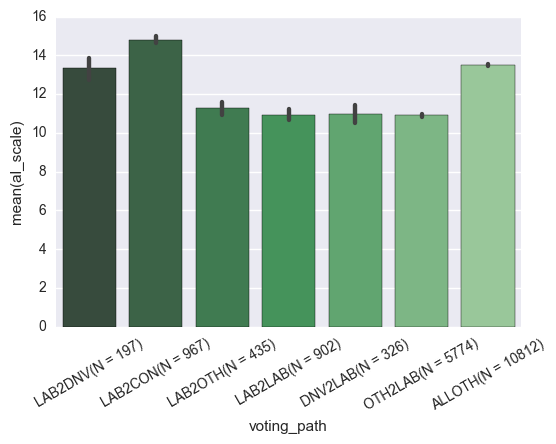

In [27]:
g = sns.barplot(x="voting_path", y="al_scale", data=df, palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);

In [28]:
df_stacked = df[["voting_path","al_scale","weights"]].dropna().copy()
df_stacked["scale"] = "al_scale"
df_stacked.columns = ["voting_path","values","weights","scale"]

In [29]:
df2_stacked = df[["voting_path","lr_scale","weights"]].dropna().copy()
df2_stacked["scale"] = "lr_scale"
df2_stacked.columns = ["voting_path","values","weights","scale"]

In [30]:
normalise = True
if normalise:
    scaler = StandardScaler()
    df_stacked["values"] = scaler.fit_transform(df_stacked["values"].values.reshape(-1,1)).reshape(1,-1)[0]
    df2_stacked["values"] = scaler.fit_transform(df2_stacked["values"].values.reshape(-1,1)).reshape(1,-1)[0]

In [31]:
df3 = df_stacked.append(df2_stacked)

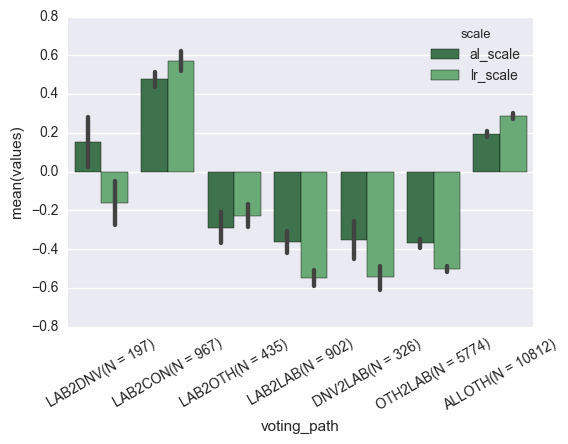

In [32]:
g = sns.barplot(x="voting_path", y="values", hue = "scale", data=df3, palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);

In [33]:
# df3 = df_stacked.append(df2_stacked)
# g = sns.violinplot(x="voting_path", y="values", hue = "scale", data=df3,
#                    palette="Greens_d", split=True, cut=0, inner=None);
# g.set_xticklabels(labels = df["voting_path"].dropna().unique(), rotation=30);

In [34]:
# df3 = df_stacked.append(df2_stacked)
# g = sns.violinplot(x="voting_path", y="values", hue = "scale", data=df3,
#                    palette="Greens_d",  cut=0);
# g.set_xticklabels(labels = df["voting_path"].dropna().unique(), rotation=30);

In [35]:
# df3 = df_stacked.append(df2_stacked)
# g = sns.violinplot(x="voting_path", y="values", hue = "scale", data=df3,
#                    palette="Greens_d", split=True, cut=0,
#                    hist_kws={'weights':df3["weights"]});
# g.set_xticklabels(labels = df["voting_path"].dropna().unique(), rotation=30);

In [36]:
# sns.distplot([2,2,2,0,0,0], hist_kws={'weights':[1,1,1,20,20,20]},bins=10)

In [37]:
# ## check that statsmodels *does* allow weights
# %matplotlib inline

# import numpy as np
# from scipy import stats
# import statsmodels.api as sm
# import matplotlib.pyplot as plt
# from statsmodels.distributions.mixture_rvs import mixture_rvs

# np.random.seed(12345)
# obs_dist1 = mixture_rvs([.25,.75], size=10000, dist=[stats.norm, stats.norm],
#                 kwargs = (dict(loc=-1,scale=.5),dict(loc=1,scale=.5)))
# kde = sm.nonparametric.KDEUnivariate(obs_dist1)
# kde.fit()

In [38]:
# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(111)
# ax.hist(obs_dist1, bins=50, normed=True, color='red')
# ax.plot(kde.support, kde.density, lw=2, color='black');

In [39]:
# weights = np.ones(obs_dist1.shape)
# weights[obs_dist1>.8] = 2

In [40]:
# gc.collect()

In [41]:

# kde = sm.nonparametric.KDEUnivariate(obs_dist1)
# kde.fit(fft=False,weights=weights)

# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(111)
# ax.hist(obs_dist1, bins=50, normed=True, color='red', weights=weights)
# ax.plot(kde.support, kde.density, lw=2, color='black');


In [42]:
# # modify these seaborn functions to allow weighted statsmodels kde!

# def _univariate_kdeplot(data, shade, vertical, kernel, bw, gridsize, cut,
#                         clip, legend, ax, cumulative=False, **kwargs):
#     """Plot a univariate kernel density estimate on one of the axes."""

#     # Sort out the clipping
#     if clip is None:
#         clip = (-np.inf, np.inf)

#     # Calculate the KDE
#     if _has_statsmodels:
#         # Prefer using statsmodels for kernel flexibility
#         ## CHANGE: ADD **kwargs here
#         x, y = _statsmodels_univariate_kde(data, kernel, bw,
#                                            gridsize, cut, clip,
#                                            cumulative=cumulative,
#                                            **kwargs)
#     else:
#         # Fall back to scipy if missing statsmodels
#         if kernel != "gau":
#             kernel = "gau"
#             msg = "Kernel other than `gau` requires statsmodels."
#             warnings.warn(msg, UserWarning)
#         if cumulative:
#             raise ImportError("Cumulative distributions are currently"
#                               "only implemented in statsmodels."
#                               "Please install statsmodels.")
#         x, y = _scipy_univariate_kde(data, bw, gridsize, cut, clip)

#     # Make sure the density is nonnegative
#     y = np.amax(np.c_[np.zeros_like(y), y], axis=1)

#     # Flip the data if the plot should be on the y axis
#     if vertical:
#         x, y = y, x

#     # Check if a label was specified in the call
#     label = kwargs.pop("label", None)

#     # Otherwise check if the data object has a name
#     if label is None and hasattr(data, "name"):
#         label = data.name

#     # Decide if we're going to add a legend
#     legend = label is not None and legend
#     label = "_nolegend_" if label is None else label

#     # Use the active color cycle to find the plot color
#     facecolor = kwargs.pop("facecolor", None)
#     line, = ax.plot(x, y, **kwargs)
#     color = line.get_color()
#     line.remove()
#     kwargs.pop("color", None)
#     facecolor = color if facecolor is None else facecolor

#     # Draw the KDE plot and, optionally, shade
#     ax.plot(x, y, color=color, label=label, **kwargs)
#     shade_kws = dict(
#         facecolor=facecolor,
#         alpha=kwargs.get("alpha", 0.25),
#         clip_on=kwargs.get("clip_on", True),
#         zorder=kwargs.get("zorder", 1),
#         )
#     if shade:
#         if vertical:
#             ax.fill_betweenx(y, 0, x, **shade_kws)
#         else:
#             ax.fill_between(x, 0, y, **shade_kws)

#     # Set the density axis minimum to 0
#     if vertical:
#         ax.set_xlim(0, None)
#     else:
#         ax.set_ylim(0, None)

#     # Draw the legend here
#     if legend:
#         ax.legend(loc="best")

#     return ax


# def _statsmodels_univariate_kde(data, kernel, bw, gridsize, cut, clip,
#                                 cumulative=False, **kwargs):
# #CHANGE: ADD **kwargs added to function input variables
#     """Compute a univariate kernel density estimate using statsmodels."""
#     fft = kernel == "gau"
#     kde = smnp.KDEUnivariate(data)
    
# #CHANGE: 
#     if "weights" in kwargs.keys():
#         print("WEIGHTS PASSED THROUGH")
#         weights = kwargs["weights"]
#         fft = False # can't use fft with weights (YET)
#     else:
#         print("WEIGHTS NOT PASSED THROUGH")        
#         weights = None
#     raise ValueError('A very specific bad thing happened')
    
#     kde.fit(kernel, bw, fft, gridsize=gridsize,
#             cut=cut, clip=clip, weights=weights)
#     if cumulative:
#         grid, y = kde.support, kde.cdf
#     else:
#         grid, y = kde.support, kde.density
#     return grid, y

# sns.distributions._statsmodels_univariate_kde = _statsmodels_univariate_kde
# sns.distributions._univariate_kdeplot = _univariate_kdeplot

In [43]:
# from gaussian_kde import gaussian_kde

In [44]:
# # unfortunately violinplot runs quite separately!

# def violinplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
#                bw="scott", cut=2, scale="area", scale_hue=True, gridsize=100,
#                width=.8, inner="box", split=False, dodge=True, orient=None,
#                linewidth=None, color=None, palette=None, saturation=.75,
#                ax=None):
#     #CHANGE: ADD **kwargs)
# #     raise ValueError('A very specific bad thing happened')
#     plotter = _ViolinPlotter(x, y, hue, data, order, hue_order,
#                              bw, cut, scale, scale_hue, gridsize,
#                              width, inner, split, dodge, orient, linewidth,
#                              color, palette, saturation)

#     if ax is None:
#         ax = plt.gca()

#     plotter.plot(ax)
#     return ax

# sns.categorical.violinplot = violinplot

# # for class _ViolinPlotter
# # CHANGE: ADD **kwargs
# def __init__(self, x, y, hue, data, order, hue_order,
#              bw, cut, scale, scale_hue, gridsize,
#              width, inner, split, dodge, orient, linewidth,
#              color, palette, saturation):
# #     raise ValueError('A very specific bad thing happened')
# #     if "weights" in kwargs.keys():
# #         self.weights = kwargs["weights"]
        
# #     else:
# #         self.weights = None
    
    
    
#     self.establish_variables(x, y, hue, data, orient, order, hue_order)
#     self.establish_colors(color, palette, saturation)
#     self.estimate_densities(bw, cut, scale, scale_hue, gridsize)

#     self.gridsize = gridsize
#     self.width = width
#     self.dodge = dodge

#     if inner is not None:
#         if not any([inner.startswith("quart"),
#                     inner.startswith("box"),
#                     inner.startswith("stick"),
#                     inner.startswith("point")]):
#             err = "Inner style '{}' not recognized".format(inner)
#             raise ValueError(err)
#     self.inner = inner

#     if split and self.hue_names is not None and len(self.hue_names) != 2:
#         msg = "There must be exactly two hue levels to use `split`.'"
#         raise ValueError(msg)
#     self.split = split

#     if linewidth is None:
#         linewidth = mpl.rcParams["lines.linewidth"]
#     self.linewidth = linewidth
    
# sns.categorical._ViolinPlotter.__init__ = __init__



# def fit_kde(self, x, bw):
#     """Estimate a KDE for a vector of data with flexible bandwidth."""
# #     self.weights = None
# #CHANGED: ADD **kwargs and this if if clause
#     if self.weights != None:
#         # use Tilla Hoffman's weighted gaussian kde
#         kde = gaussian_kde(x, bw, weights=self.weights[x.shape[0]])
#     else:
#         raise ValueError('A very specific bad thing happened')
#         # Allow for the use of old scipy where `bw` is fixed
#         try:
#             kde = stats.gaussian_kde(x, bw)
#         except TypeError:
#             kde = stats.gaussian_kde(x)
#             if bw != "scott":  # scipy default
#                 msg = ("Ignoring bandwidth choice, "
#                        "please upgrade scipy to use a different bandwidth.")
#                 warnings.warn(msg, UserWarning)

#     # Extract the numeric bandwidth from the KDE object
#     bw_used = kde.factor

#     # At this point, bw will be a numeric scale factor.
#     # To get the actual bandwidth of the kernel, we multiple by the
#     # unbiased standard deviation of the data, which we will use
#     # elsewhere to compute the range of the support.
#     bw_used = bw_used * x.std(ddof=1)

#     return kde, bw_used

# sns.categorical._ViolinPlotter.fit_kde = fit_kde


In [45]:
# from gaussian_kde import gaussian_kde
# import matplotlib as mpl


# def fit_kde(self, x, bw):
#     """Estimate a KDE for a vector of data with flexible bandwidth."""
#     # Allow for the use of old scipy where `bw` is fixed
#     #raise ValueError('A very specific bad thing happened')
#   #  self.weights = None
# #CHANGED: ADD **kwargs and this if if clause

# #     self.weights = None
#     if self.weights is not None:
# #         print(x.shape[0], self.weights[x.shape[0]])
#         # use Tilla Hoffman's weighted gaussian kde
#         kde = gaussian_kde(x, bw, weights=self.weights[x.shape[0]])
#     else:
# #         raise ValueError('A very specific bad thing happened')
#         try:
#             kde = stats.gaussian_kde(x, bw)
#         except TypeError:
#             kde = stats.gaussian_kde(x)
#             if bw != "scott":  # scipy default
#                 msg = ("Ignoring bandwidth choice, "
#                        "please upgrade scipy to use a different bandwidth.")
#                 warnings.warn(msg, UserWarning)

#     # Extract the numeric bandwidth from the KDE object
#     bw_used = kde.factor

#     # At this point, bw will be a numeric scale factor.
#     # To get the actual bandwidth of the kernel, we multiple by the
#     # unbiased standard deviation of the data, which we will use
#     # elsewhere to compute the range of the support.
#     bw_used = bw_used * x.std(ddof=1)

#     return kde, bw_used
    
# sns.categorical._ViolinPlotter.fit_kde = fit_kde
# #################################################

# def __init__(self, x, y, hue, data, order, hue_order,
#              bw, cut, scale, scale_hue, gridsize,
#              width, inner, split, orient, linewidth,
#              color, palette, saturation, **kwargs):

#   #  raise ValueError('A very specific bad thing happened')
#     if "weights" in kwargs.keys():
#         self.weights = kwargs["weights"]
# #         raise ValueError('A very specific bad thing happened')
#     else:
#         self.weights = None    
    
#     self.establish_variables(x, y, hue, data, orient, order, hue_order)
#     self.establish_colors(color, palette, saturation)
#     self.estimate_densities(bw, cut, scale, scale_hue, gridsize)

#     self.gridsize = gridsize
#     self.width = width

#     if inner is not None:
#         if not any([inner.startswith("quart"),
#                     inner.startswith("box"),
#                     inner.startswith("stick"),
#                     inner.startswith("point")]):
#             err = "Inner style '{}' not recognized".format(inner)
#             raise ValueError(err)
#     self.inner = inner

#     if split and self.hue_names is not None and len(self.hue_names) != 2:
#         raise ValueError("Cannot use `split` with more than 2 hue levels.")
#     self.split = split

#     if linewidth is None:
#         linewidth = mpl.rcParams["lines.linewidth"]
#     self.linewidth = linewidth
    
    
# sns.categorical._ViolinPlotter.__init__ = __init__


# ############################################################


# def violinplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
#                bw="scott", cut=2, scale="area", scale_hue=True, gridsize=100,
#                width=.8, inner="box", split=False, orient=None, linewidth=None,
#                color=None, palette=None, saturation=.75, ax=None, **kwargs):

#     kw_string = ', '.join(['{}={!r}'.format(k, v) for k, v in kwargs.items()])    
    
#  #   raise ValueError("dfdfdf", kw_string)
# #     raise ValueError('A very specific bad thing happened')
    
#     # Try to handle broken backwards-compatability
#     # This should help with the lack of a smooth deprecation,
#     # but won't catch everything
#     warn = False
#     if isinstance(x, pd.DataFrame):
#         data = x
#         x = None
#         warn = True

#     if "vals" in kwargs:
#         x = kwargs.pop("vals")
#         warn = True

#     if "groupby" in kwargs:
#         y = x
#         x = kwargs.pop("groupby")
#         warn = True

#     if "vert" in kwargs:
#         vert = kwargs.pop("vert", True)
#         if not vert:
#             x, y = y, x
#         orient = "v" if vert else "h"
#         warn = True

#     msg = ("The violinplot API has been changed. Attempting to adjust your "
#            "arguments for the new API (which might not work). Please update "
#            "your code. See the version 0.6 release notes for more info.")
#     if warn:
#         warnings.warn(msg, UserWarning)
#     # CHANGE: ADD ,**kwargs
#     plotter = sns.categorical._ViolinPlotter(x, y, hue, data, order, hue_order,
#                              bw, cut, scale, scale_hue, gridsize,
#                              width, inner, split, orient, linewidth,
#                              color, palette, saturation, **kwargs)

#     if ax is None:
#         ax = plt.gca()

#     plotter.plot(ax)
#     return ax

# sns.categorical.violinplot = violinplot



In [46]:
weights = {}
for scale in df3["scale"].unique():
    for voting_path in df3["voting_path"].unique():
        wgts = df3[ (df3["scale"]==scale) & (df3["voting_path"]==voting_path) ]["weights"].values
        wgts_len = wgts.shape[0]
        
        if np.isnan(wgts).any():
            raise ValueError("nan in the weights!")
        
        if wgts_len not in weights.keys():
            weights[wgts_len] = wgts
        else:
            raise ValueError("This hack only works if the size of each group is different!")
            
            # non-lazy way of doing same thing - create a hash!
            

In [47]:
# import inspect
# inspect.getsourcelines(sns.categorical._ViolinPlotter.__init__)

In [48]:
gc.collect()

6688

In [49]:
# inspect.getsourcelines(sns.violinplot)

In [50]:


# fig, ax = plt.subplots(figsize=(9,5))
# #cut=0,
# if normalise:
#     kwargs = {}
#     graph_name = 'Lab_vote_path_by_values_weighted_normalised'
# else:
#     kwargs = {"cut":0}
#     graph_name = 'Lab_vote_path_by_values_weighted'
# df3 = df_stacked.append(df2_stacked)
# g = sns.categorical.violinplot(x="voting_path", y="values", hue = "scale", data=df3,
#                    palette="Greens_d", split=True,  inner=None, order=order, 
#                    weights=weights, ax=ax, **kwargs);
# g.set_xticklabels(labels = order, rotation=10);

# fig.savefig(BES_data_folder+graph_name+'.png')

In [51]:
# df3 = df_stacked.append(df2_stacked)
# g = sns.categorical.violinplot(x="voting_path", y="values", hue = "scale", data=df3, order=order,
#                    palette="Greens_d", split=True, cut=0, inner=None, weights=None);
# g.set_xticklabels(labels = order, rotation=30);

In [52]:
######### LDA on these categories


In [53]:
wave = "W13_only"

BES_numeric = pd.read_hdf( BES_data_folder+"BESnumeric"+wave+".hdf", "BESnumeric"+wave )
print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_hdf( BES_data_folder+"var_type"+wave+".hdf", "var_type" )
print("var_type",  var_type.shape )
BES_reduced = pd.read_hdf( BES_data_folder+"BES_reduced"+wave+".hdf", "BES_reduced"+wave )
print("BES_reduced",  BES_reduced.shape )

fname = BES_data_folder+"cat_dictionary"+wave+".pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )

BES_numeric (31197, 300)
var_type (312, 1)
BES_reduced (31197, 306)


In [54]:
BES_reduced[ constraints ].shape

(19413, 306)

In [55]:
constraints = England & Wave13 & (LAB2CON[0] | LAB2OTH[0] | LAB2LAB[0] | DNV2LAB[0] | OTH2LAB[0])
#  LAB2DNV[0] | 
# ALLOTH/LAB2DNV overlap!!!

# constraints = England & (lost | kept | gained | never)

clean_feature_set_std = StandardScaler().fit_transform(BES_reduced[ constraints ].values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced[ constraints ].columns,
                             index   = BES_reduced[ constraints ].index      )

# BES_std = BES_std\
#     .drop([x for x in BES_reduced.columns if ("generalElectionVote" in x) | ("profile_past_vote_2015" in x)],axis=1)\
#     .drop(["genElecTurnoutRetro_Yes, voted", 'profile_turnout_2015_Yes, voted'],axis=1)\
#     .drop([x for x in BES_reduced.columns if "gor" in x],axis=1)

used_vars = ["generalElectionVote_Labour",
             "genElecTurnoutRetro_Yes, voted"]
used_vars =[]
# ,
#              "profile_past_vote_2015_Labour",
#              'profile_turnout_2015_Yes, voted'

BES_std = BES_std\
    .drop(used_vars,axis=1)\

# train_cols, target
df["voting_path"] = df["voting_path"].astype('category').cat.reorder_categories(order)

# find not_independent variables
tol = 15
BES_std["voting_path"]=df["voting_path"].cat.codes
Q, R = np.linalg.qr(BES_std.as_matrix())
not_independent = np.where(np.abs(R.diagonal()) <= tol)[0]
print( BES_std.columns[not_independent] )
BES_std = BES_std.drop(BES_std.columns[not_independent], axis=1)
BES_std = BES_std.drop("voting_path",axis=1)

BES_std = BES_std.drop([x for x in BES_std.columns if "generalElectionVote" in x], axis=1)
BES_std = BES_std.drop([x for x in BES_std.columns if "ptv" in x], axis=1)
BES_std = BES_std.drop('likeLab__Strongly like', axis=1)
BES_std = BES_std.drop(['partyId_Conservative',
     'partyId_Liberal Democrat',
     'partyId_United Kingdom Independence Party (UKIP)',
     'partyId_Scottish National Party (SNP)',
     'partyId_Green Party'], axis=1)
BES_std = BES_std.drop([x for x in BES_std.columns if "profile_past_vote_2015" in x], axis=1)
BES_std = BES_std.drop(['likeMay__Strongly like',
     'likeCorbyn__Strongly like',
     'likeFarron__Strongly like',
     'likeSturgeon__Strongly like',
     'likeNuttall__Strongly like',
     'likeLucas__Strongly like',
     'likeCon__Strongly like',
     'likeLD__Strongly like',
     'likeSNP__Strongly like',
     'likeUKIP__Strongly like',
     'likeGrn__Strongly like',
     'likeRudd__Strongly like',
     'likeBoris__Strongly like',
     'likeDavis__Strongly like'], axis=1)
BES_std = BES_std.drop(['bestOnMII_Labour',
 'bestOnMII_United Kingdom Independence Party (UKIP)',
 'bestOnMII_Liberal Democrat',
 'bestOnMII_Green Party',
 'bestOnMII_Other party'], axis=1)

Index(['generalElectionVote_Plaid Cymru', 'partyId_Plaid Cymru',
       'bestOnMII_Scottish National Party (SNP)', 'bestOnMII_Plaid Cymru',
       'gor_Wales', 'gor_North East',
       'education_Youth training certificate/skillseekers',
       'profile_newspaper_The Western Mail',
       'profile_past_vote_2015_Scottish National Party (SNP)',
       'profile_past_vote_2015_Plaid Cymru', 'genElecTurnoutRetro_Yes, voted'],
      dtype='object')


In [56]:
X = BES_std.as_matrix()                  
y = df["voting_path"][ constraints ].cat.codes    
target_names = df["voting_path"][ constraints ].cat.categories


decomp_var_names = BES_std.columns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

FA = FactorAnalysis(svd_method = 'lapack', n_components=2)
X_FA = FA.fit_transform(X)

# lda =LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
#               solver='svd', store_covariance=False, tol=0.1)
# lda =LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=.9,
#               solver='eigen')
lda =LinearDiscriminantAnalysis(n_components=len( df["voting_path"][ constraints ].unique() ) -1)
X_lda = lda.fit(X, y).transform(X)
lda.coef_ = -lda.coef_ # to get them in the same orientation as pca components!

In [57]:
decomp = lda
if decomp == lda:
    X_r2 = X_lda
    n_components = lda.n_components
elif decomp == pca:
    X_r2 = X_pca
    n_components = pca.n_components
elif decomp == FA:
    X_r2 = X_FA
    n_components = FA.n_components    



BES_decomp = pd.DataFrame(   X_r2,
                             columns = range(0 , n_components),
                             index   = BES_reduced[ constraints ].index)

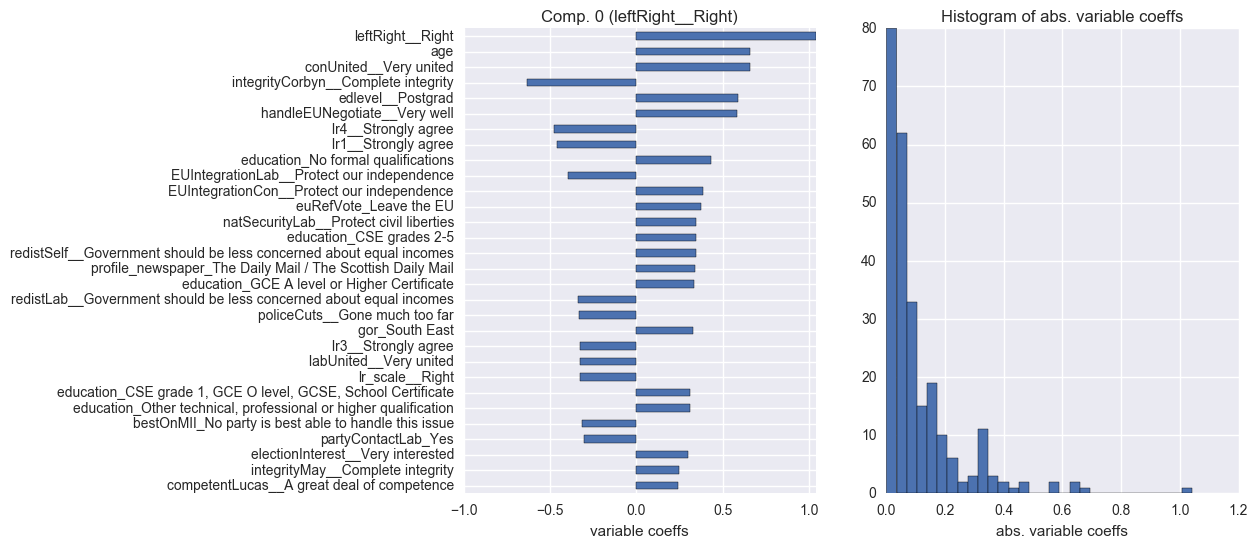

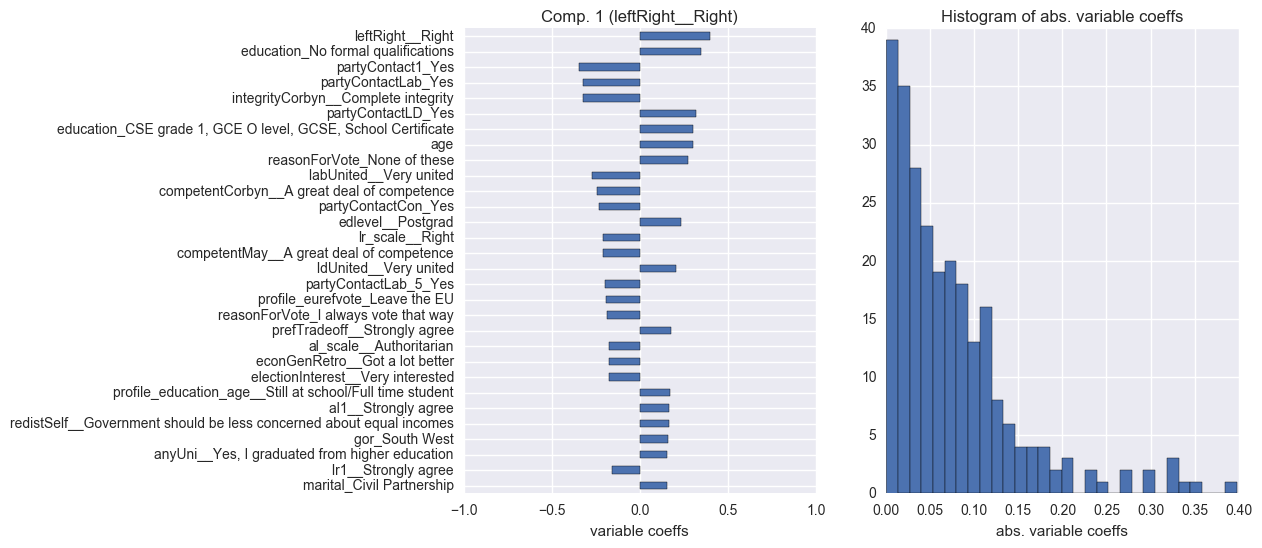

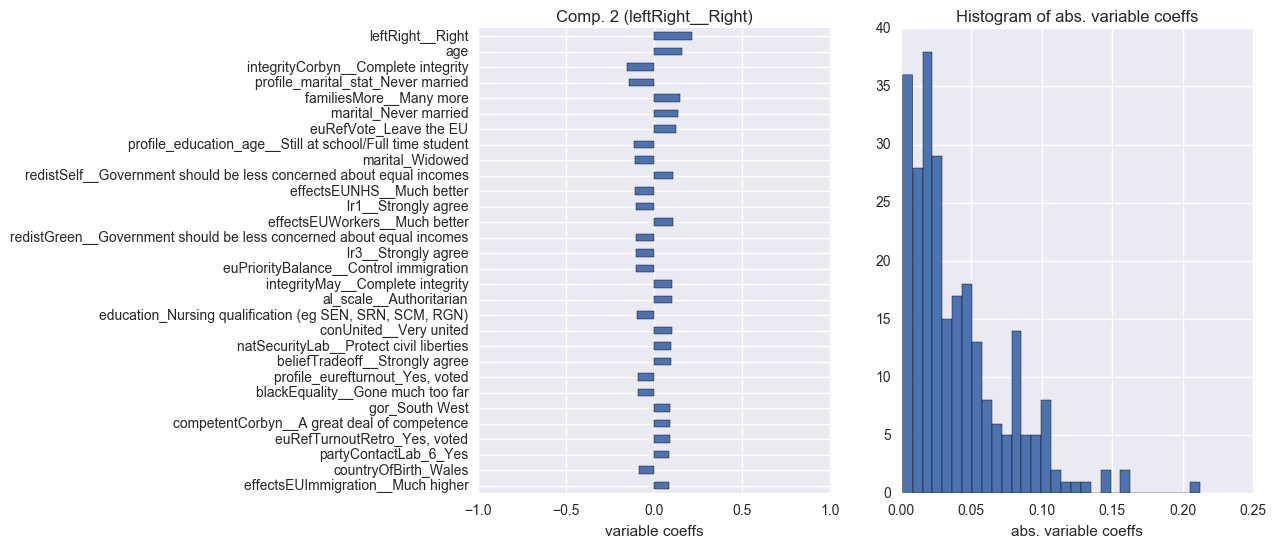

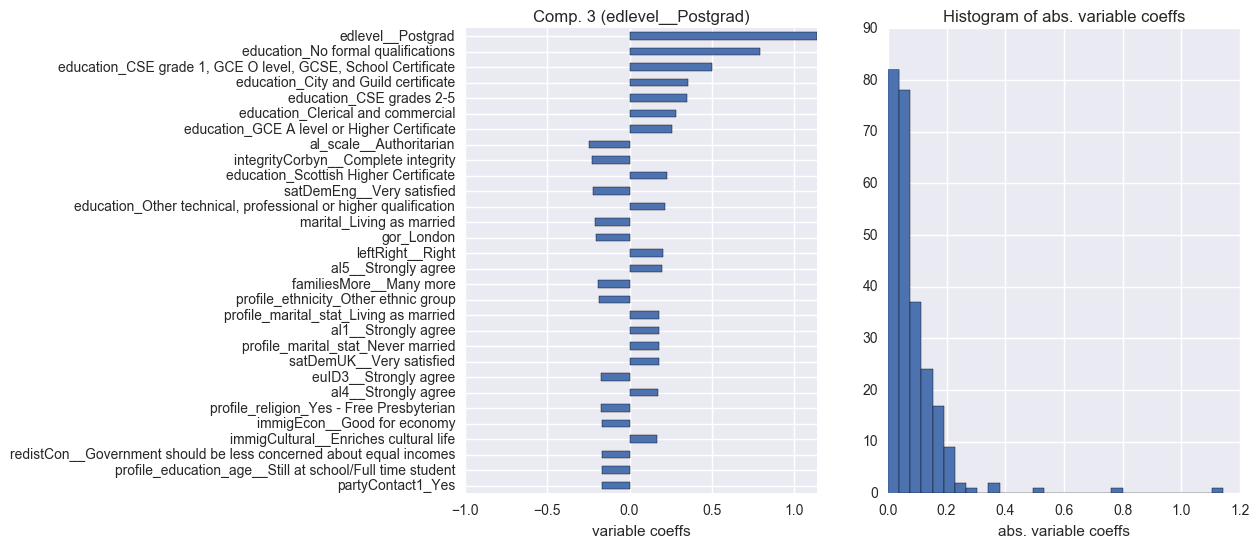

In [58]:
treatdir = BES_data_folder+"W13_Lab_groups"
if not os.path.exists(treatdir): os.makedirs(treatdir)

decomp_method = str(decomp).split("(")[0] 
decomp_method_subdir = treatdir + os.sep + decomp_method
if not os.path.exists(decomp_method_subdir): os.makedirs(decomp_method_subdir)
    
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          cols = decomp_var_names, BES_decomp = BES_decomp,
                                                          save_folder = decomp_method_subdir, 
                                                          show_first_x_comps= 4, show_histogram = True)

In [59]:
x_axis=0
y_axis=1

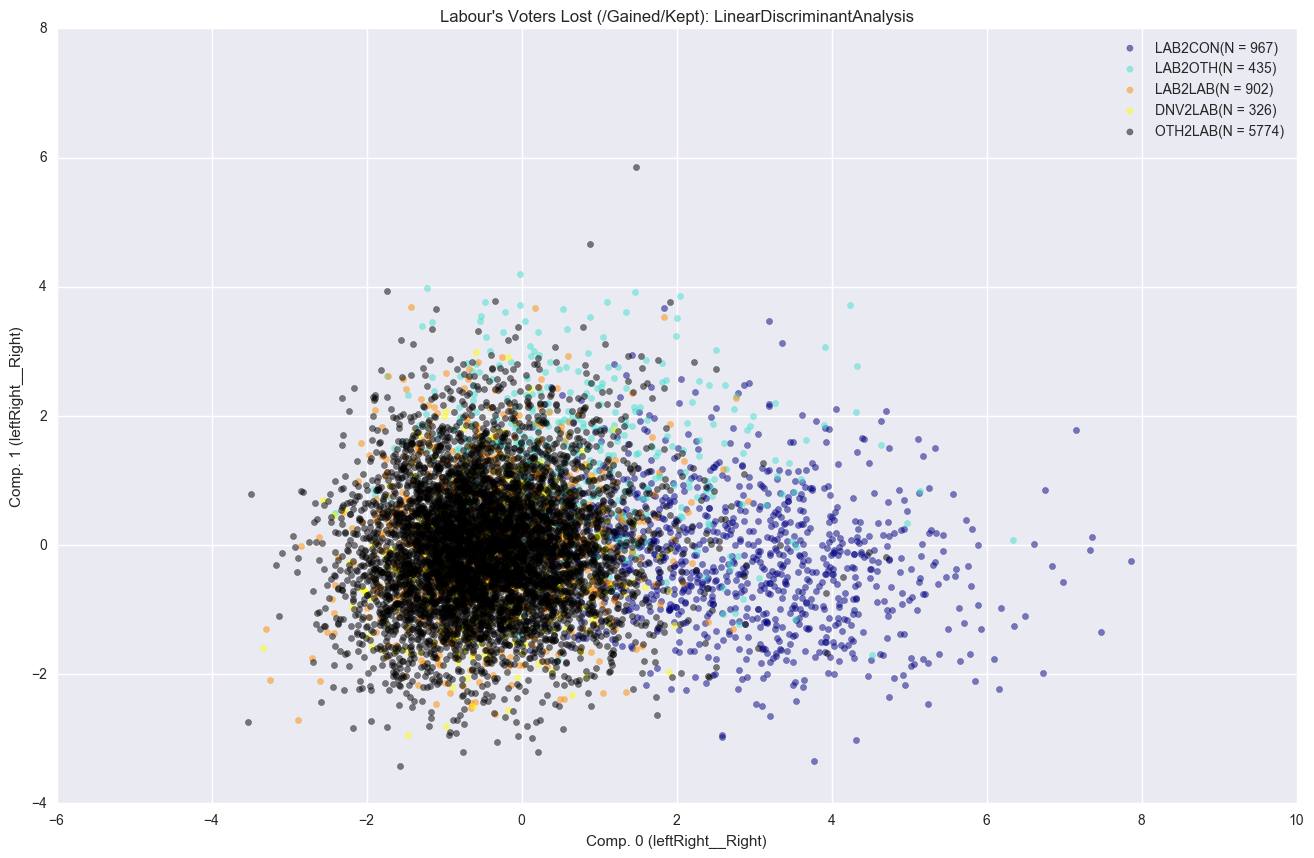

In [60]:
colors = ['navy', 'turquoise', 'darkorange', 'yellow', 'black', 'green', 'red']

X_r2 = BES_decomp.values

seq = [1, 2, 3, 4, 5]

plt.figure(figsize=(16,10))
for color, i, target_name in zip(colors, seq, target_names[seq]):
    type_arr = np.array(y == i,dtype='bool')
    plt.scatter(X_r2[type_arr, 0], X_r2[type_arr, 1], alpha=.5, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Labour\'s Voters Lost (/Gained/Kept): ' + decomp_method)
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 

plt.show()

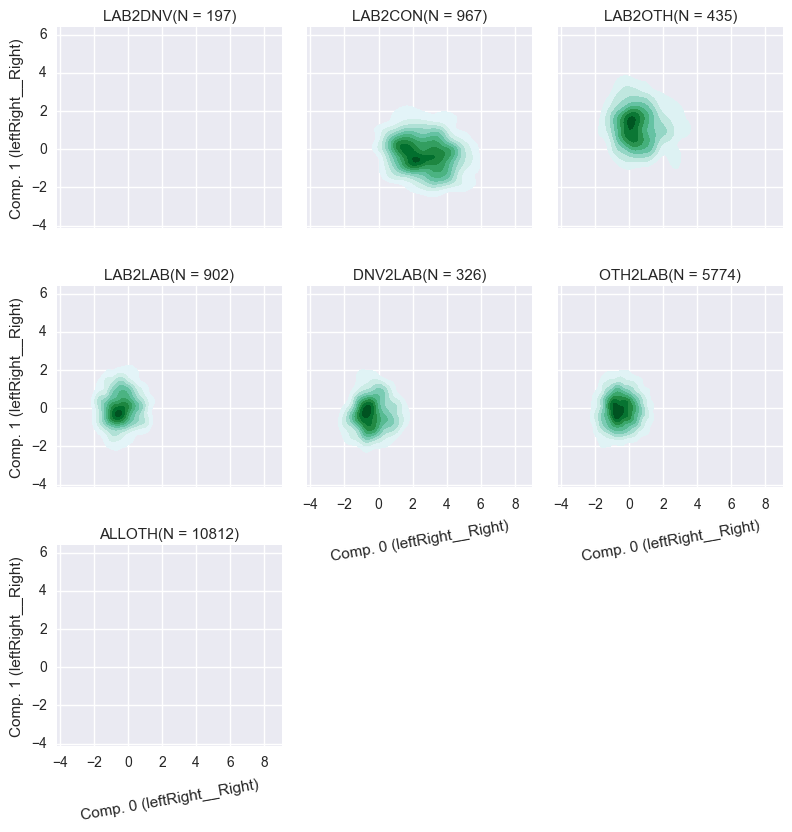

In [61]:
fig = plt.figure( figsize=(16,10) )

# X_r = decomp.fit_transform(BES_std)
# n_components = 2
# BES_decomp = pd.DataFrame(   decomp.transform(BES_reduced[constraints])[:, [x_axis,y_axis]],
#                              columns = range(0,n_components),
#                              index   = BES_reduced[England].index)

# (BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
#                                                           save_folder = False, cols = BES_reduced.columns,
#                                                           BES_decomp = BES_decomp, show_first_x_comps= 0)


col = "voting_path"
BES_decomp[col] = df["voting_path"][ constraints ]
col_wrap = 3
size = 13.5*.6/col_wrap

cats = BES_decomp[col].cat.categories

# add N=??? sample size to each category type!
# sample_sizes = BES_decomp[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# BES_decomp[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

g = sns.FacetGrid(BES_decomp, col="voting_path", col_wrap=col_wrap, size=size)
g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")


g.set_xlabels( comp_labels[x_axis], rotation=10 )
g.set_ylabels( comp_labels[y_axis] )

if decomp==pca:
    plt.xlim((-14,10))
    plt.ylim((-8,8))
elif decomp==FA:
    plt.xlim((-3,3))
    plt.ylim((-3,3))   

g.savefig(decomp_method_subdir+os.sep+"kde"+'.png')

In [62]:
# so, lets poke at some of those variables

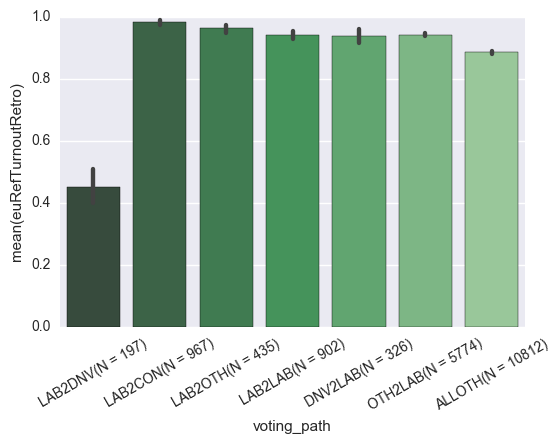

In [63]:
# okay- what differentiates LAB -> DNV ... is that they didn't vote in other elections
g = sns.barplot(x=df["voting_path"], y=(BES_Panel.euRefTurnoutRetro=="Yes, voted"), palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);

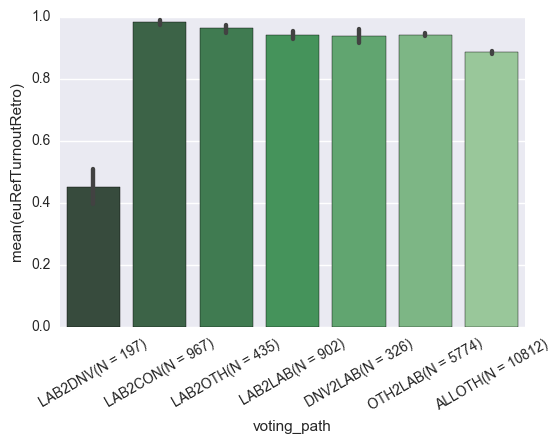

In [64]:
# okay- what differentiates LAB -> DNV ... is that they didn't vote in other elections
g = sns.barplot(x=df["voting_path"], y=(BES_Panel.euRefTurnoutRetro=="Yes, voted"), palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);

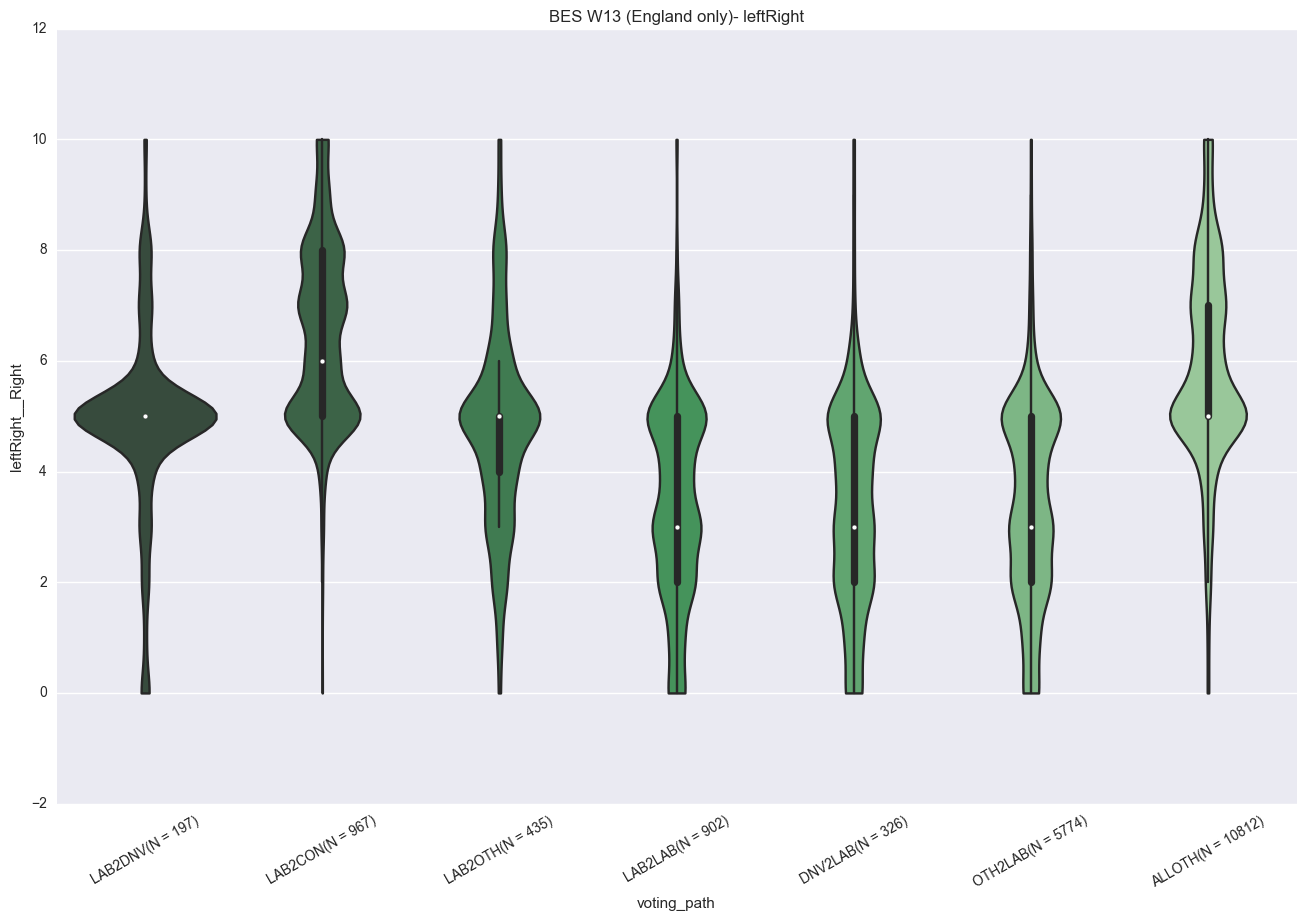

In [106]:
fig = plt.figure( figsize=(16,10) )
g = sns.categorical.violinplot(x=df["voting_path"][England], y=BES_reduced.leftRight__Right[England], bw=.25, cut=0, 
                   palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- leftRight"
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')

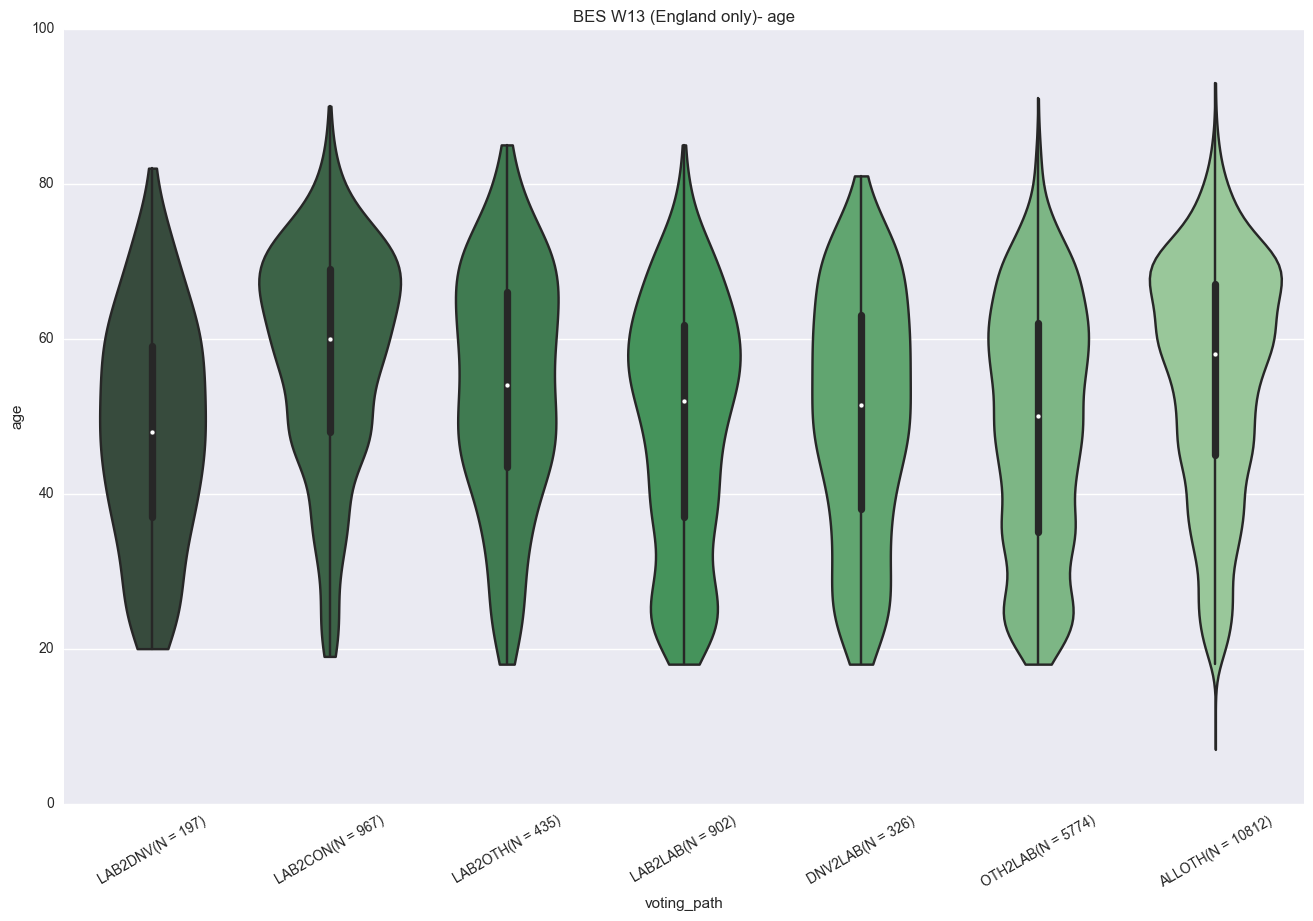

In [110]:
fig = plt.figure( figsize=(16,10) )
y=BES_reduced.age[England]
g = sns.violinplot(x=df["voting_path"][England], y=y, cut=0, 
                   palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- age"
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')

In [117]:
# hmm - when is 'age' recorded for? reference year? How were these people able to vote in 2005?
# Or is it the party they *would* have voted for?

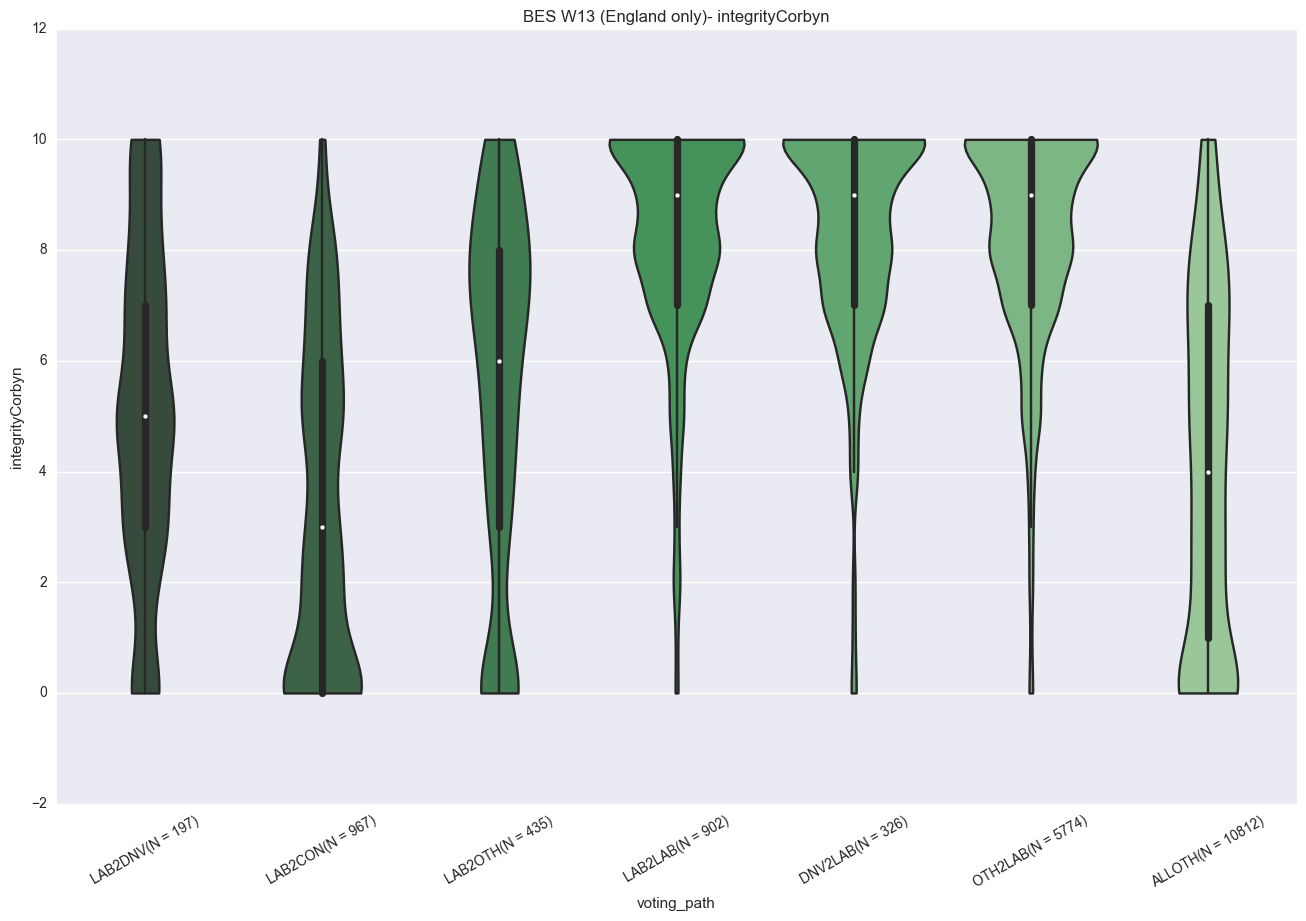

In [130]:
fig = plt.figure( figsize=(16,10) )
var = 'integrityCorbyn'
y= BES_numeric['integrityCorbyn'][England]
g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=.25, cut=0, 
                   palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + var
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')




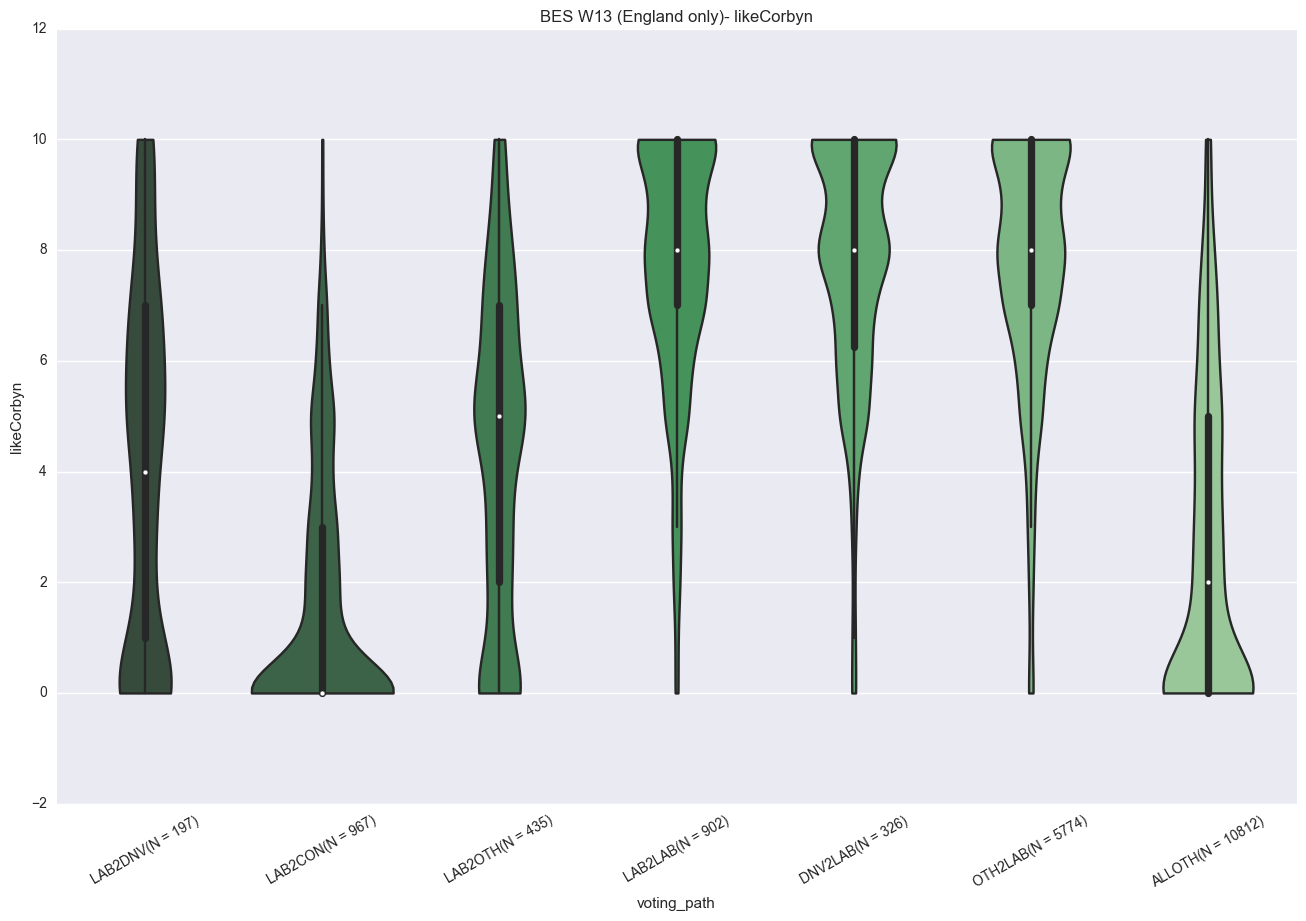

In [132]:
fig = plt.figure( figsize=(16,10) )
var = 'likeCorbyn'
y= BES_numeric[var][England]
g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=.25, cut=0, 
                   palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + var
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')




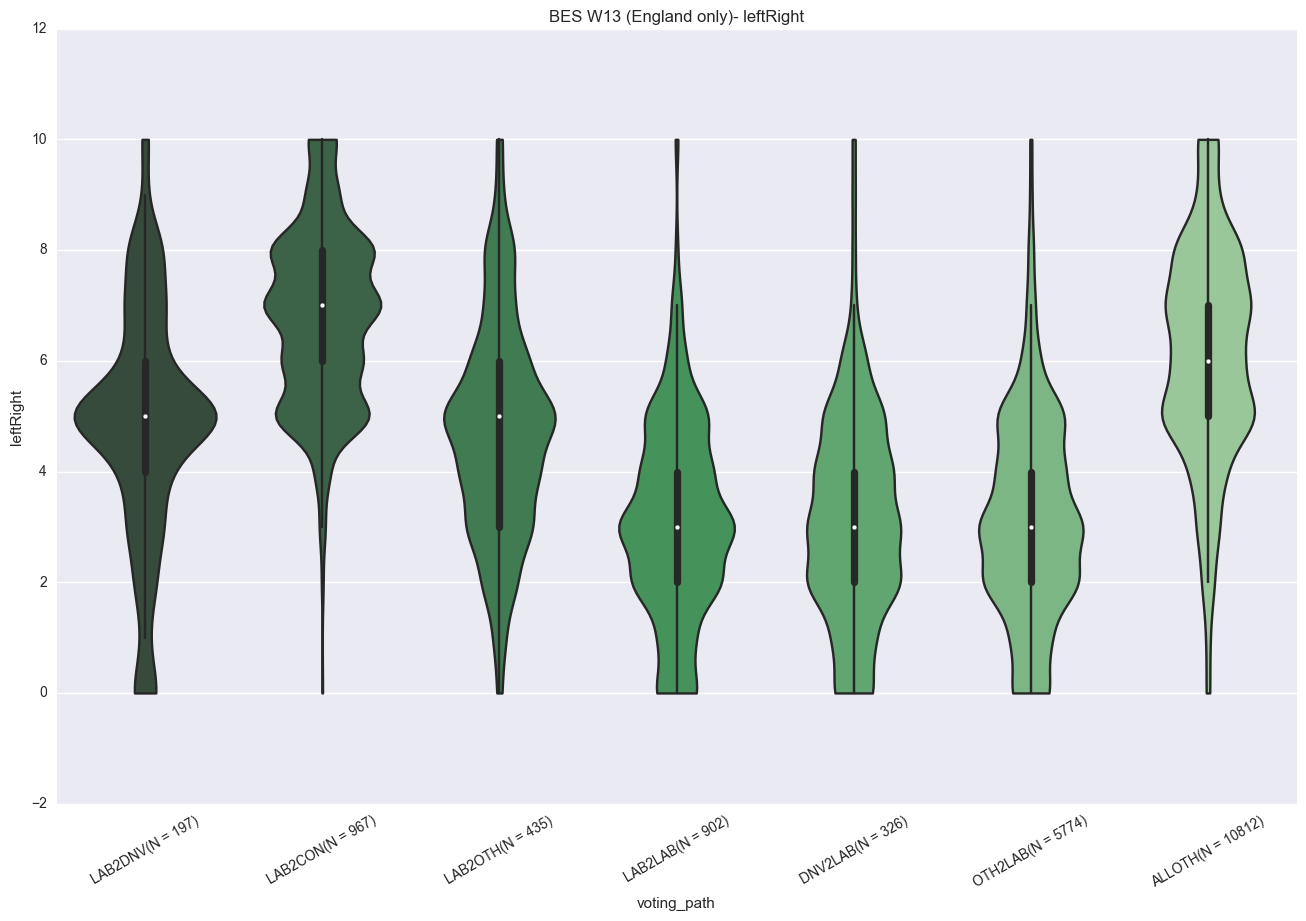

In [135]:
fig = plt.figure( figsize=(16,10) )
var = 'leftRight'
y= BES_numeric[var][England]
g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=.25, cut=0, 
                   palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + var
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')

# 


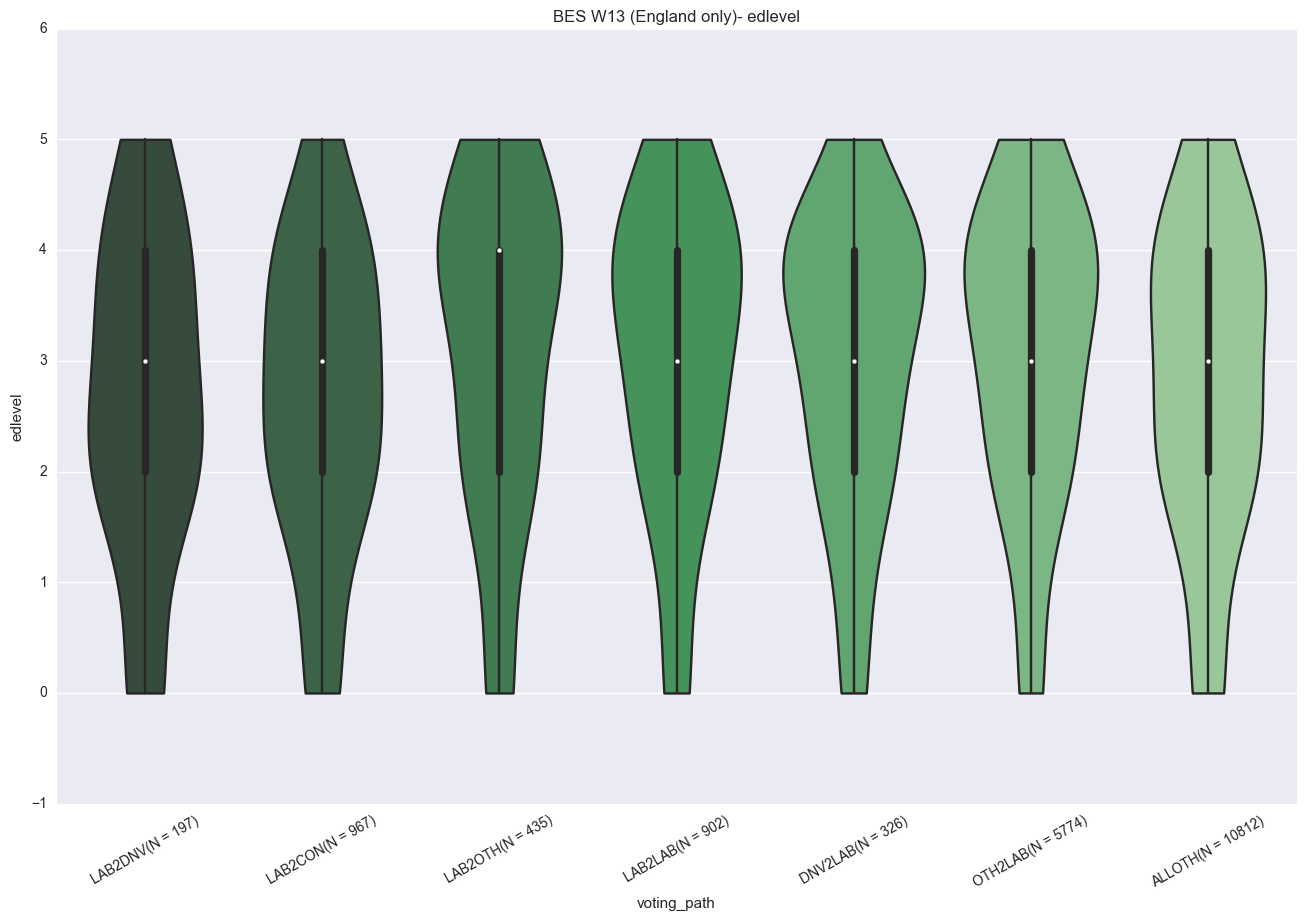

In [140]:
fig = plt.figure( figsize=(16,10) )
var = 'edlevel'
y= BES_numeric[var][England]
g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=.5, cut=0, 
                   palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + var
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')




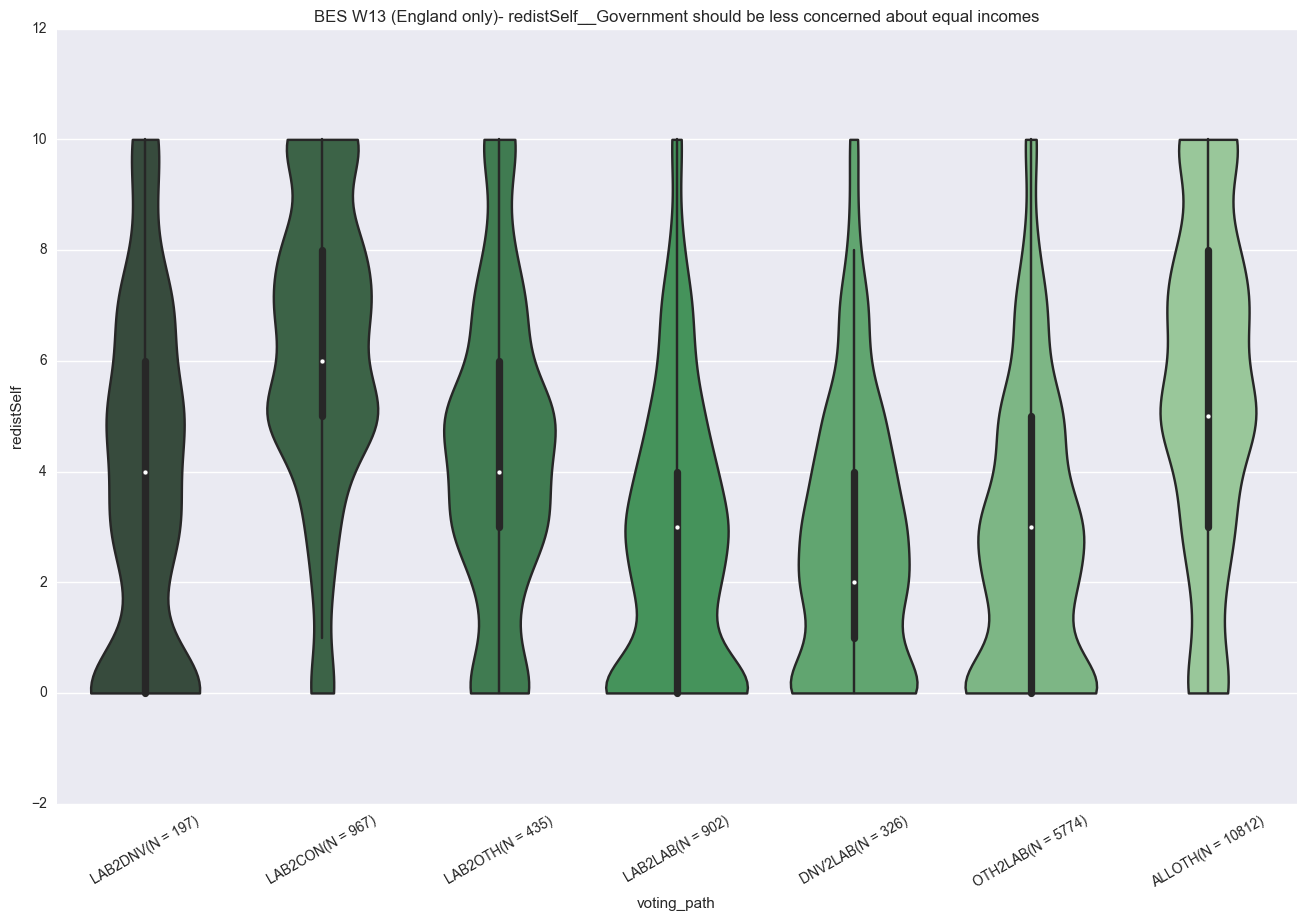

In [155]:
fig = plt.figure( figsize=(16,10) )
var = 'redistSelf'
y= BES_numeric[var][England]
g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=.25, cut=0, 
                   palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')




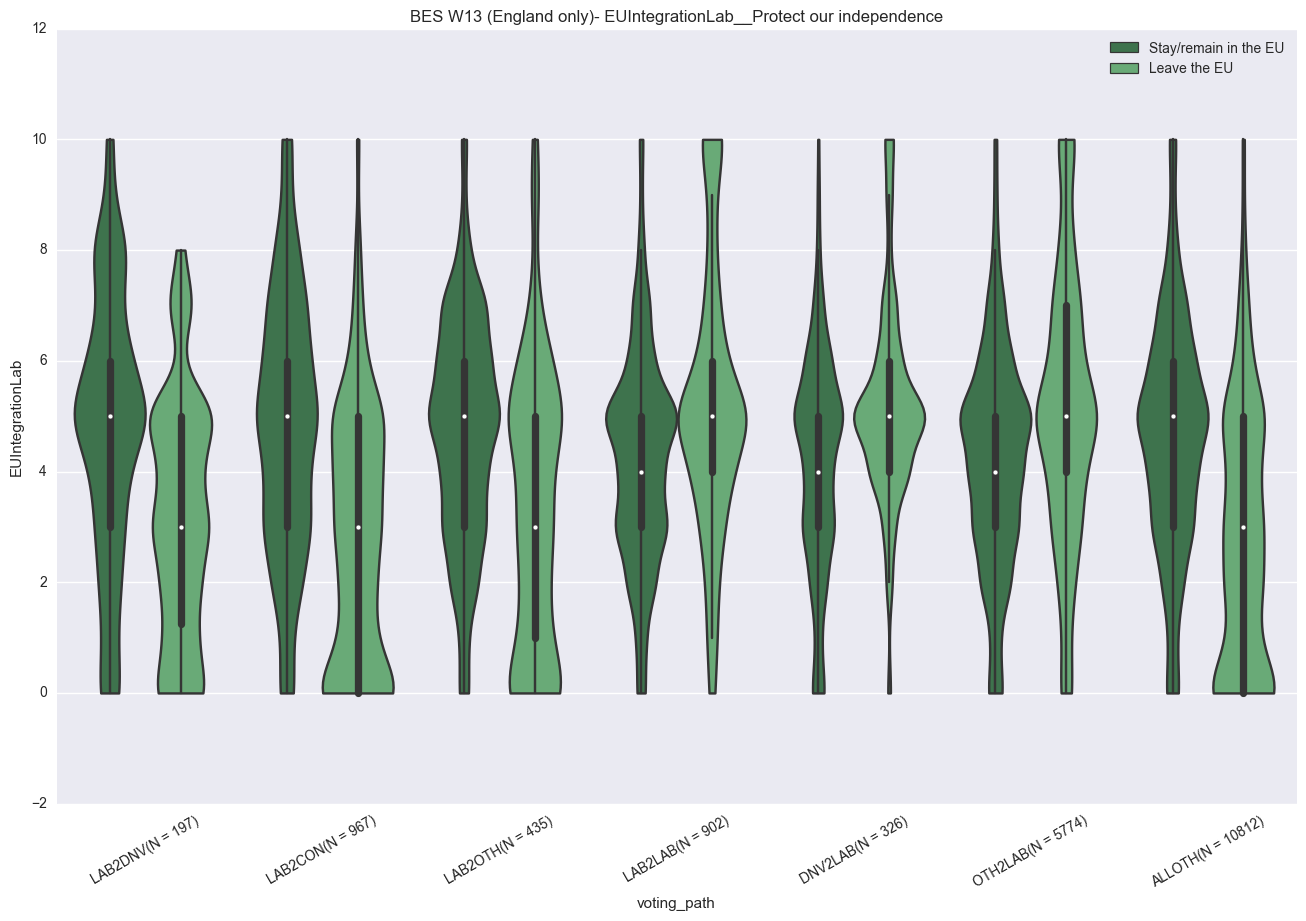

In [166]:
fig = plt.figure( figsize=(16,10) )
var = 'EUIntegrationLab'
y= BES_numeric[var][England]
hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=.25, cut=0, hue= hue,
                   palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')






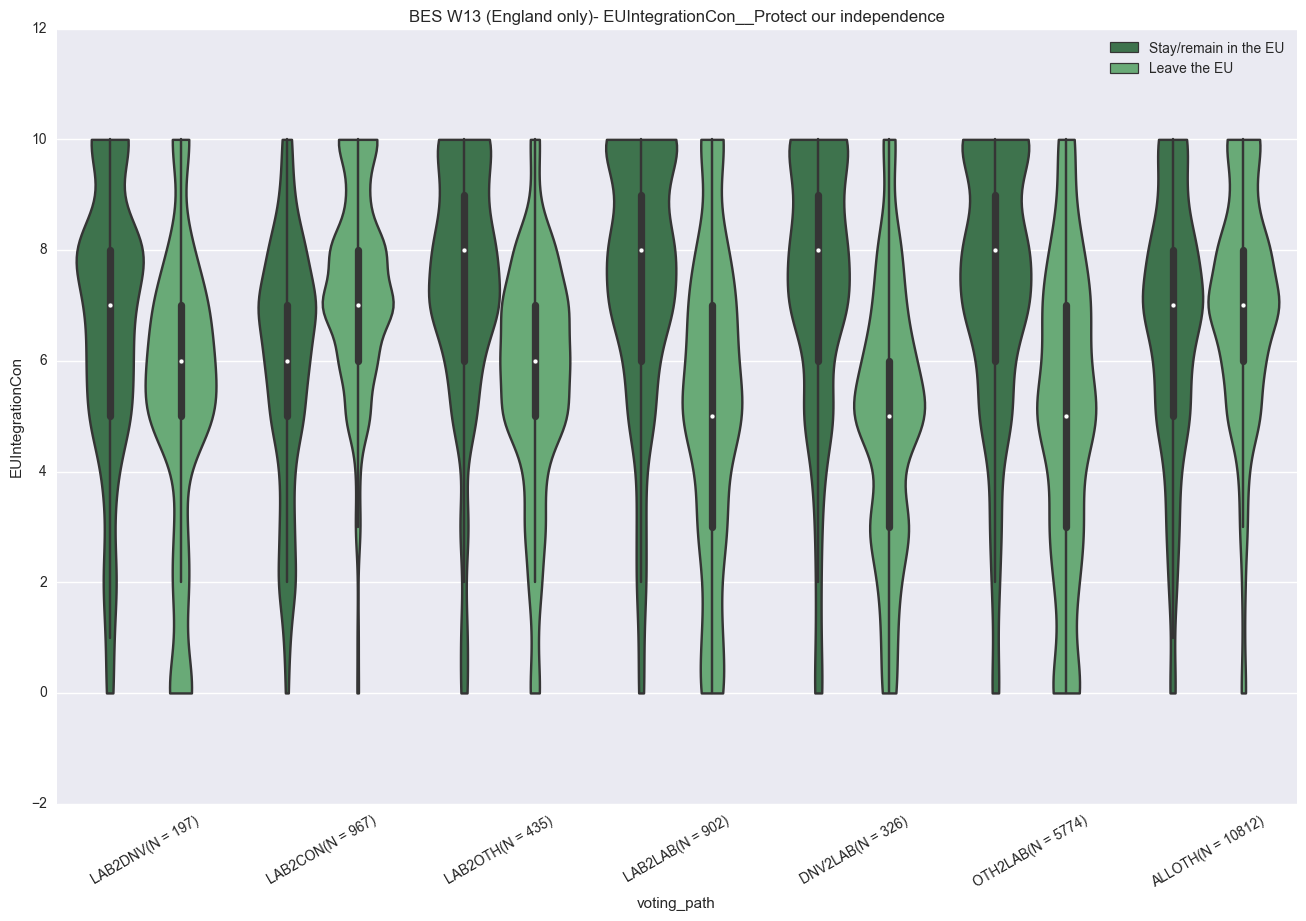

In [168]:
fig = plt.figure( figsize=(16,10) )
var = 'EUIntegrationCon'
y= BES_numeric[var][England]
hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=.25, cut=0, hue= hue,
                   palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')






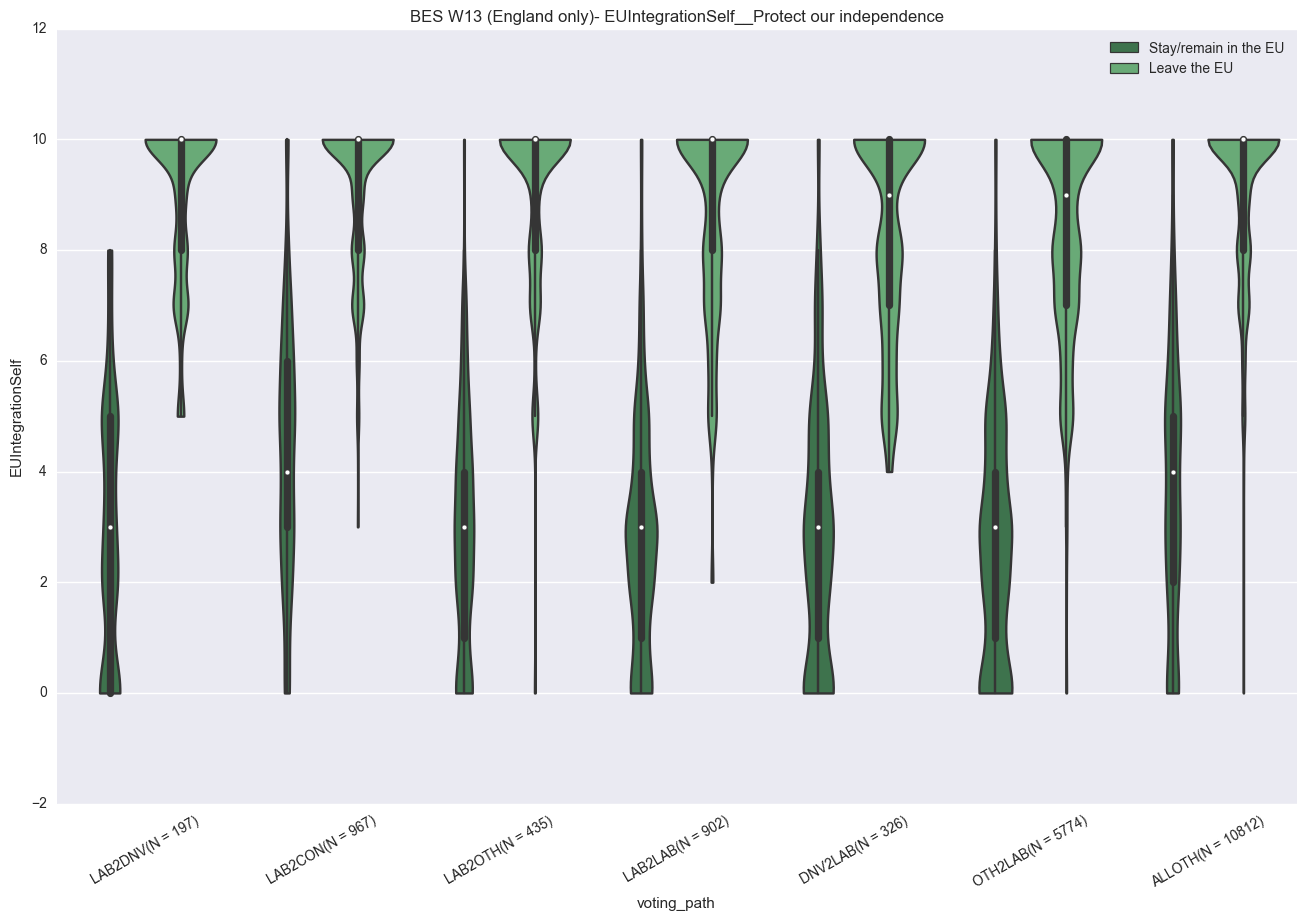

In [182]:
fig = plt.figure( figsize=(16,10) )
var = 'EUIntegrationSelf'
y= BES_numeric[var][England]
hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=.25, cut=0, hue= hue,
                   palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')






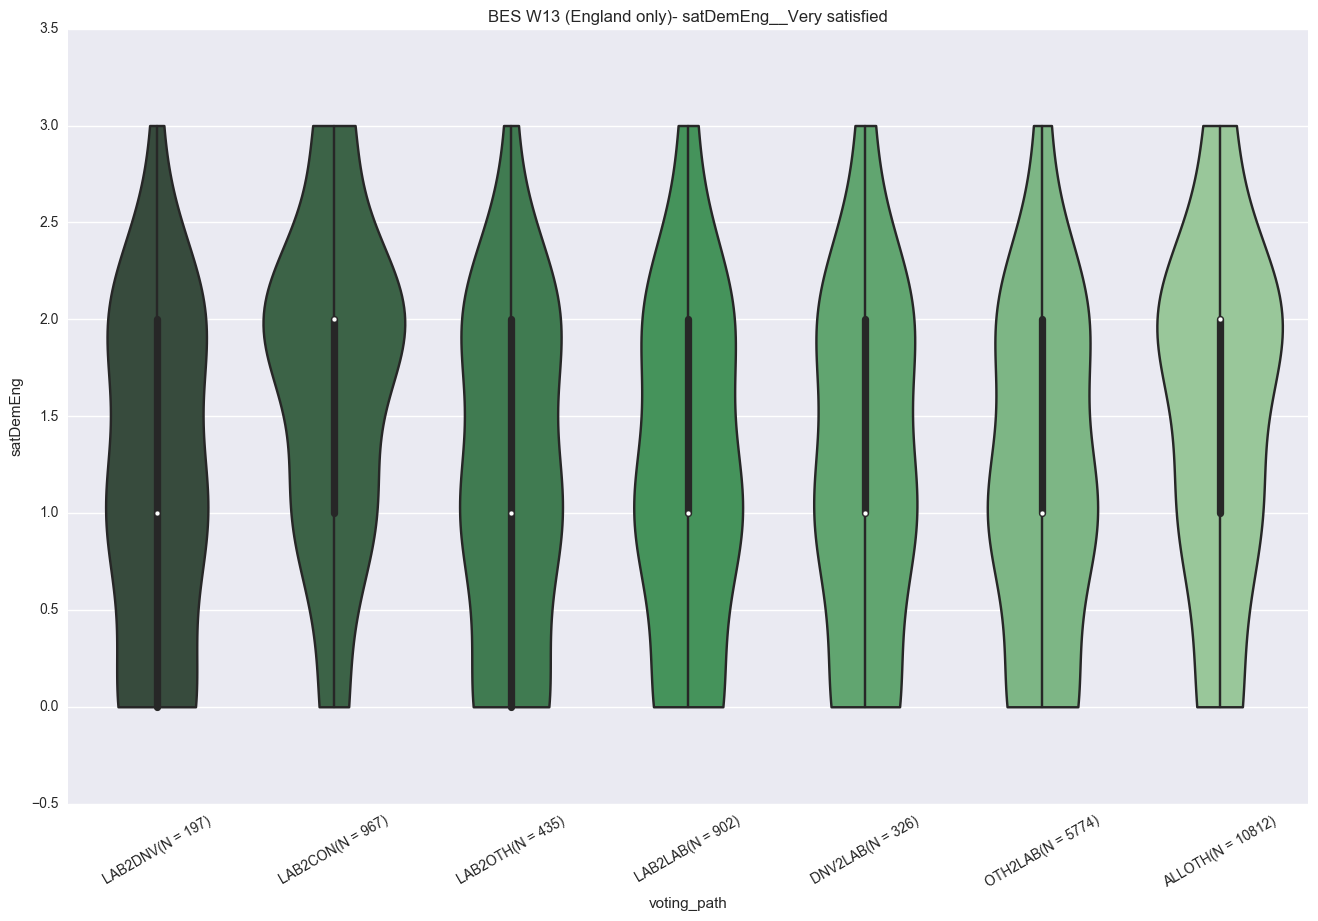

In [175]:
fig = plt.figure( figsize=(16,10) )
var = 'satDemEng'
y= BES_numeric[var][England]
# hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=.5, cut=0,
                   palette="Greens_d", order=order);
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')






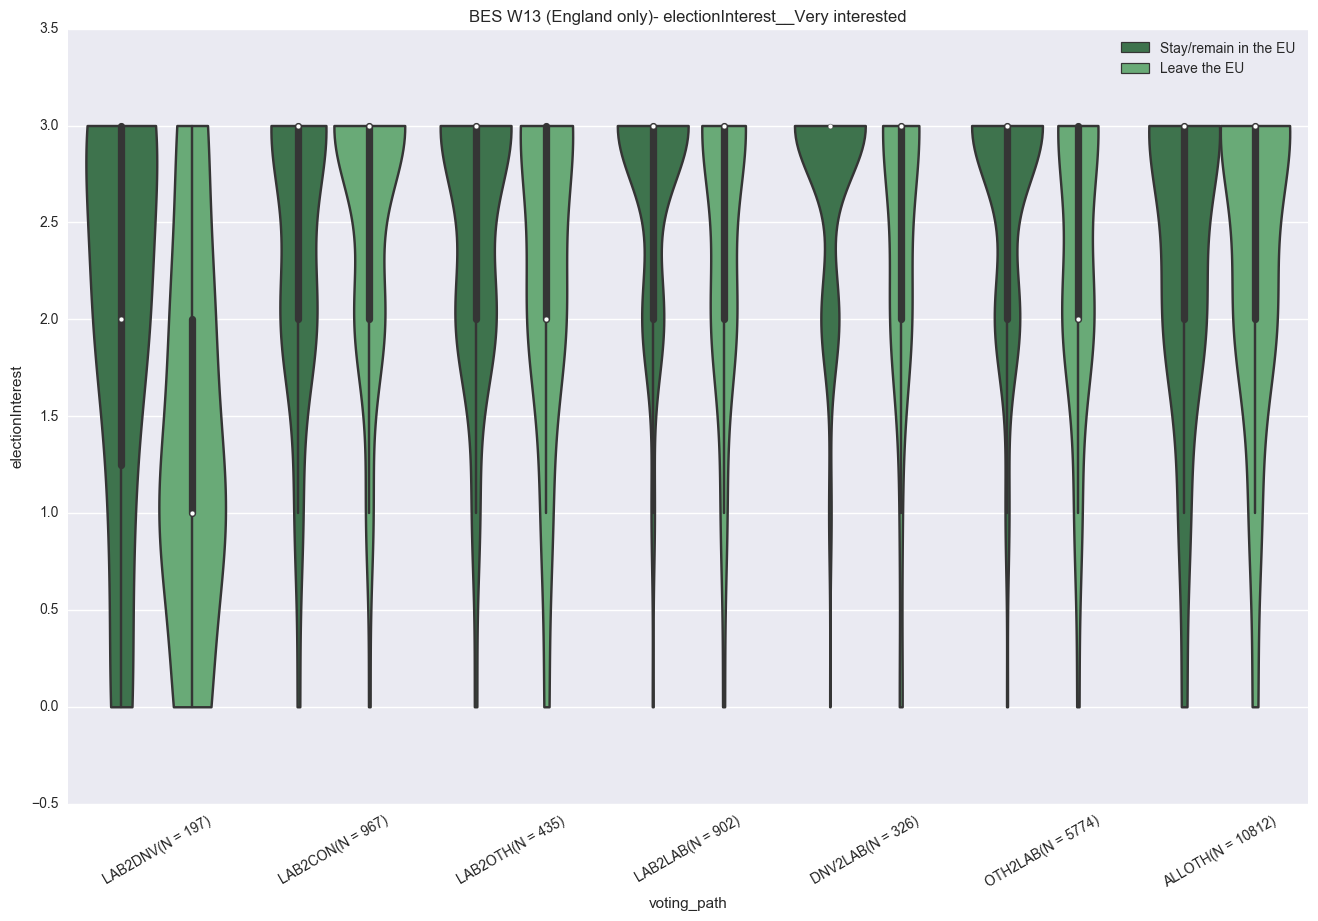

In [185]:
fig = plt.figure( figsize=(16,10) )
var = 'electionInterest'
y= BES_numeric[var][England]
bw = .5
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')






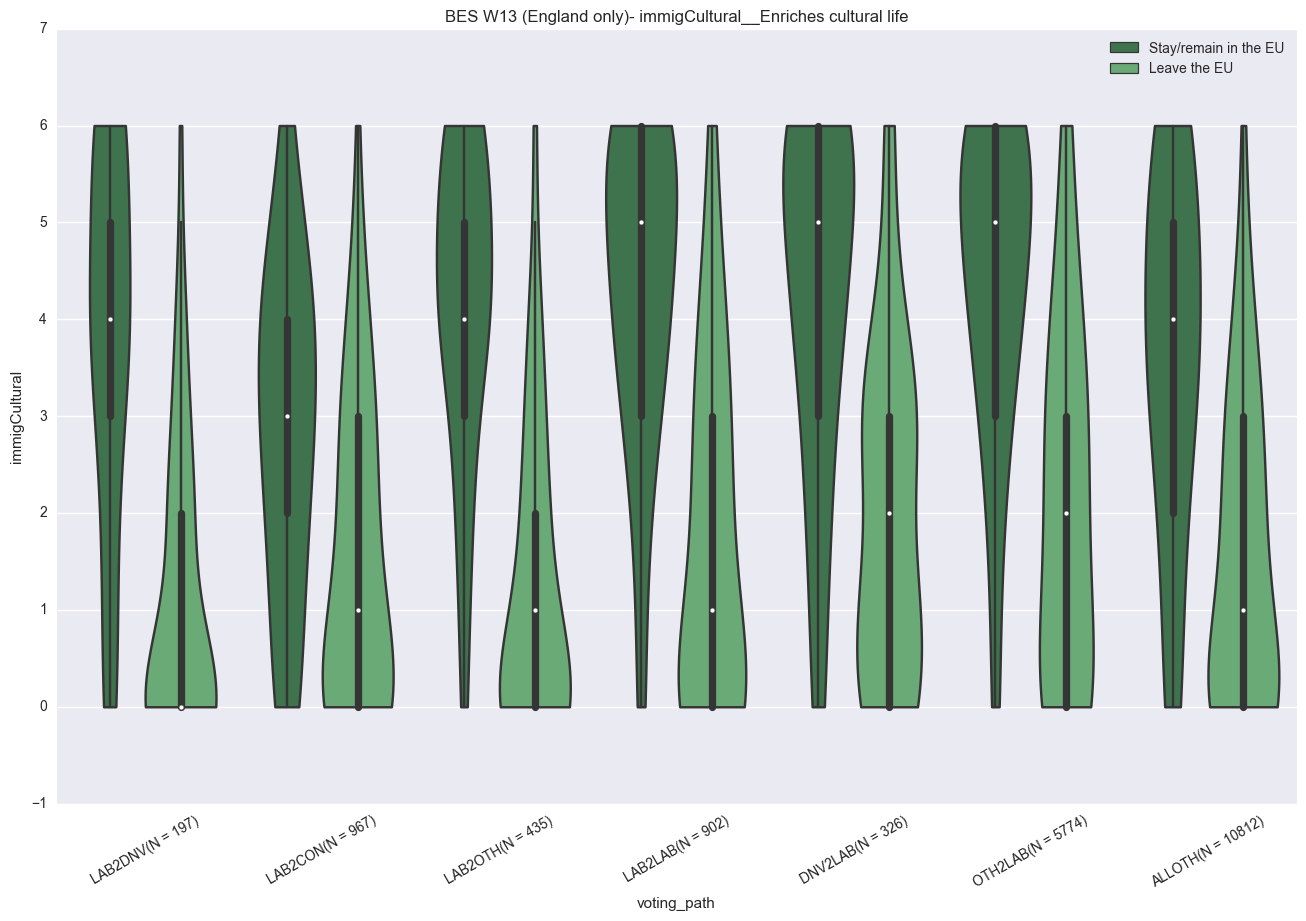

In [186]:
fig = plt.figure( figsize=(16,10) )
var = 'immigCultural'
y= BES_numeric[var][England]
bw = .5
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



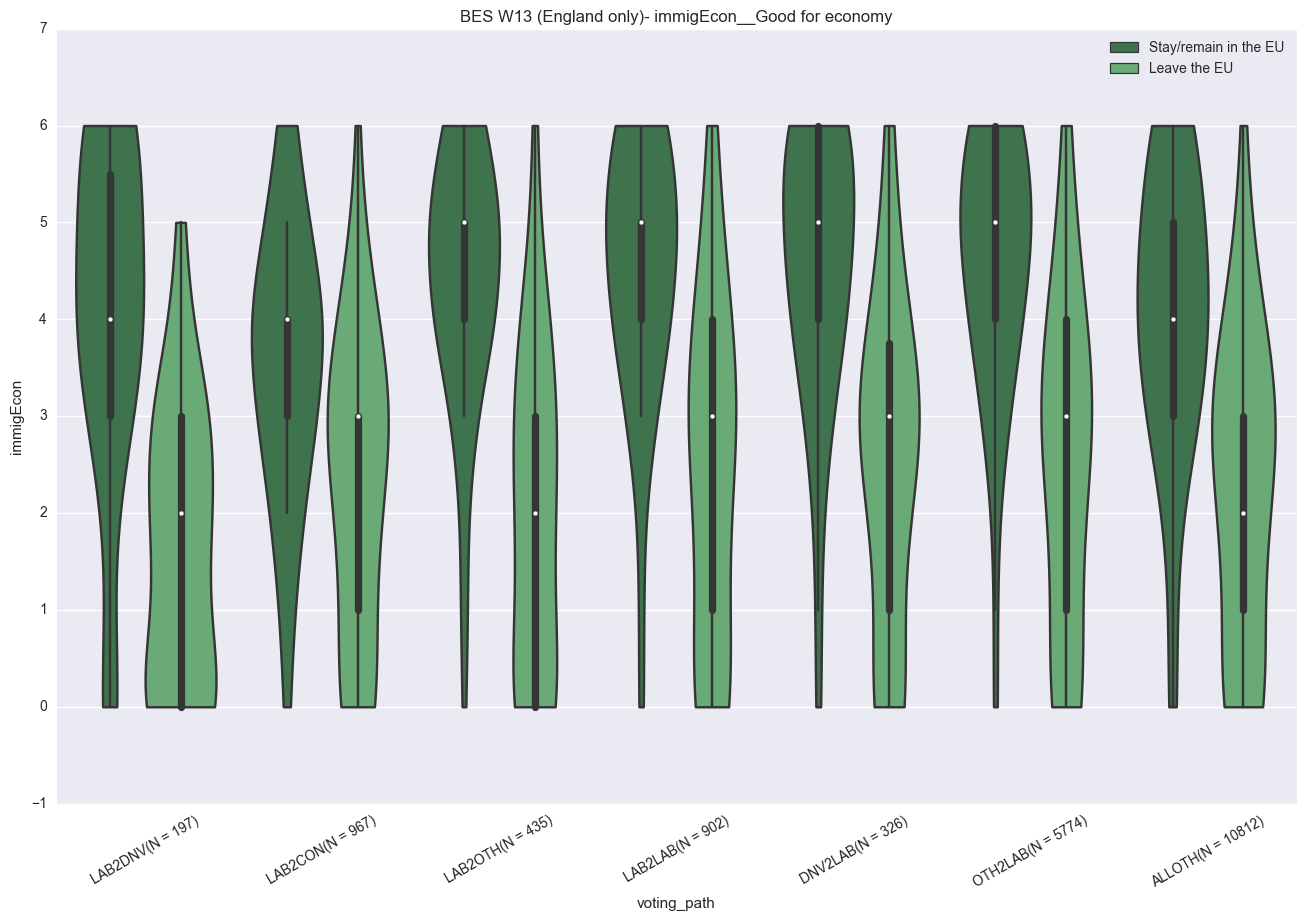

In [191]:
fig = plt.figure( figsize=(16,10) )
var = 'immigEcon'
y= BES_numeric[var][England]
bw = .5
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



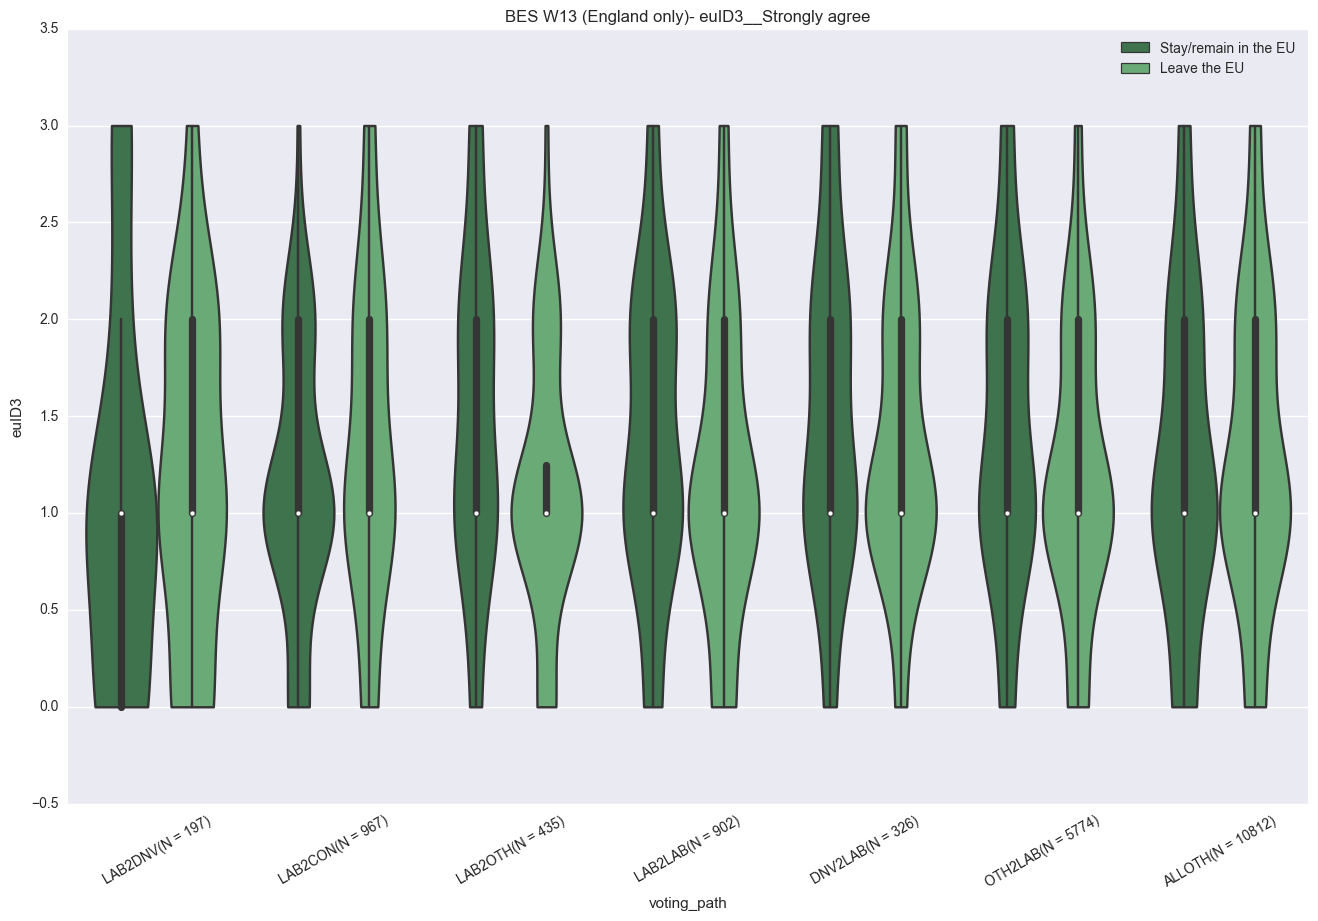

In [195]:
# When people criticise the Leave/Remain camp, it feels like a personal insult

fig = plt.figure( figsize=(16,10) )
var = 'euID3'
y= BES_numeric[var][England]
bw = .5
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



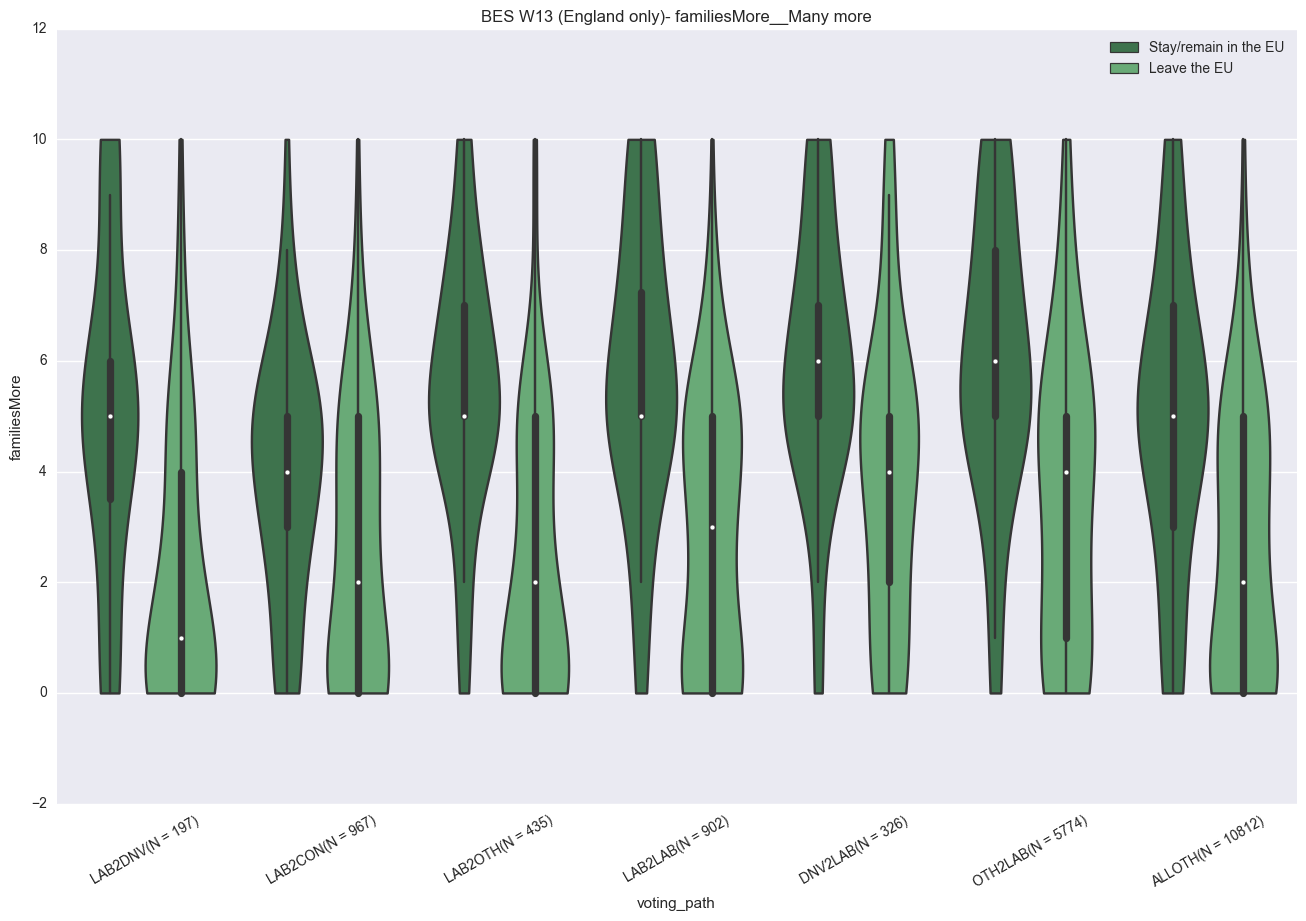

In [196]:
# more immigration from families!

fig = plt.figure( figsize=(16,10) )
var = 'familiesMore'
y= BES_numeric[var][England]
bw = .5
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



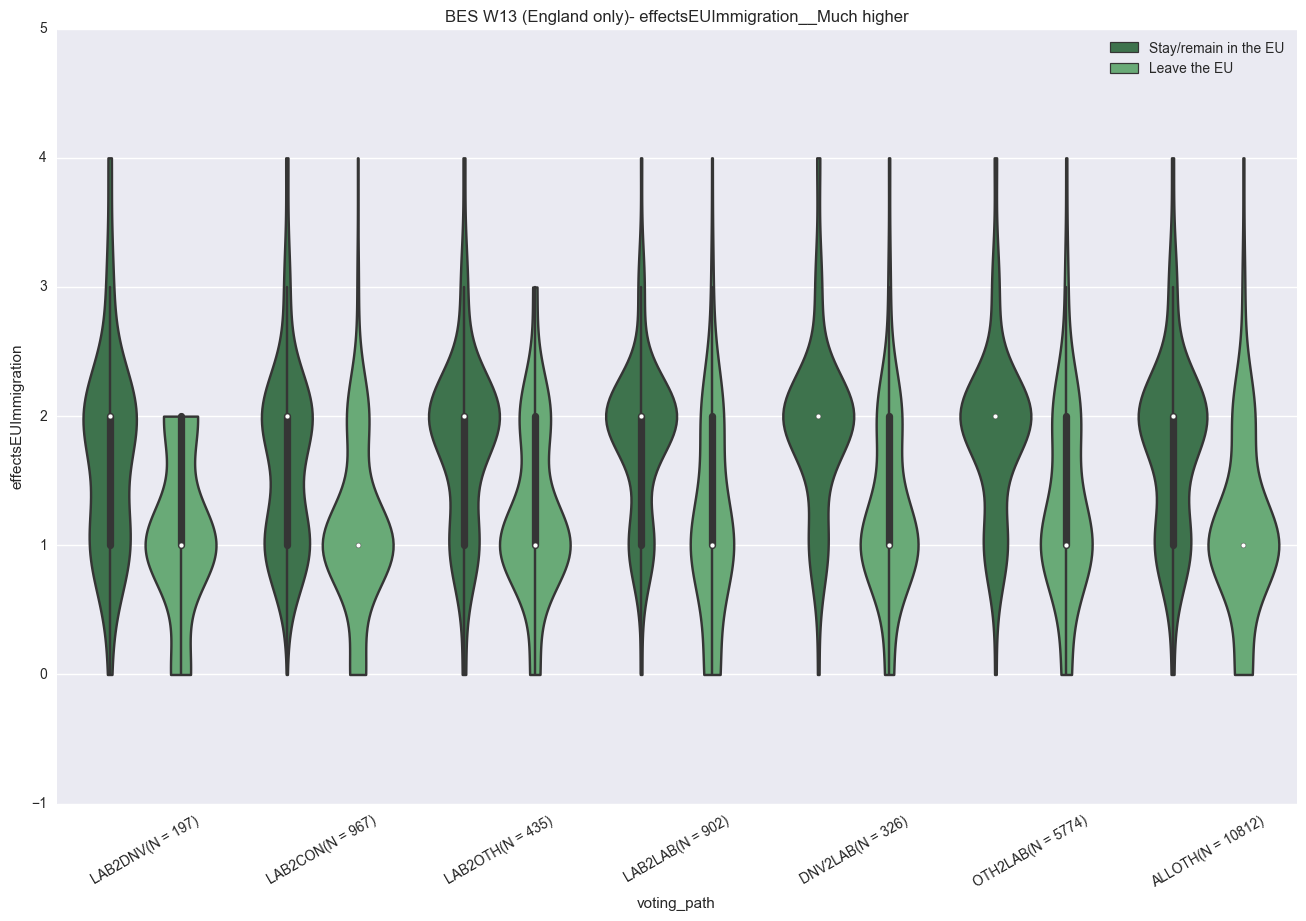

In [197]:

fig = plt.figure( figsize=(16,10) )
var = 'effectsEUImmigration'
y= BES_numeric[var][England]
bw = .5
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



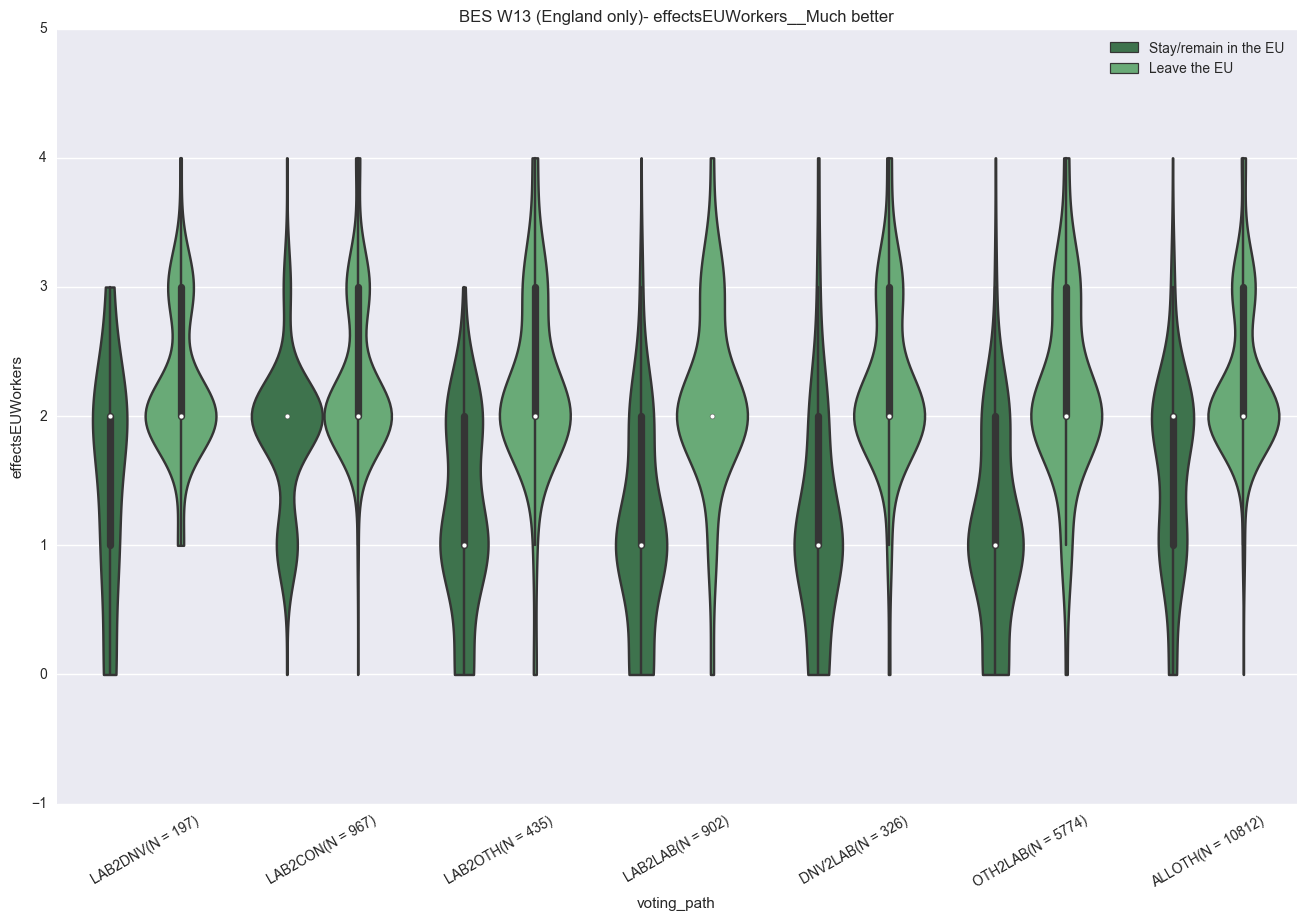

In [198]:

fig = plt.figure( figsize=(16,10) )
var = 'effectsEUWorkers'
y= BES_numeric[var][England]
bw = .5
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



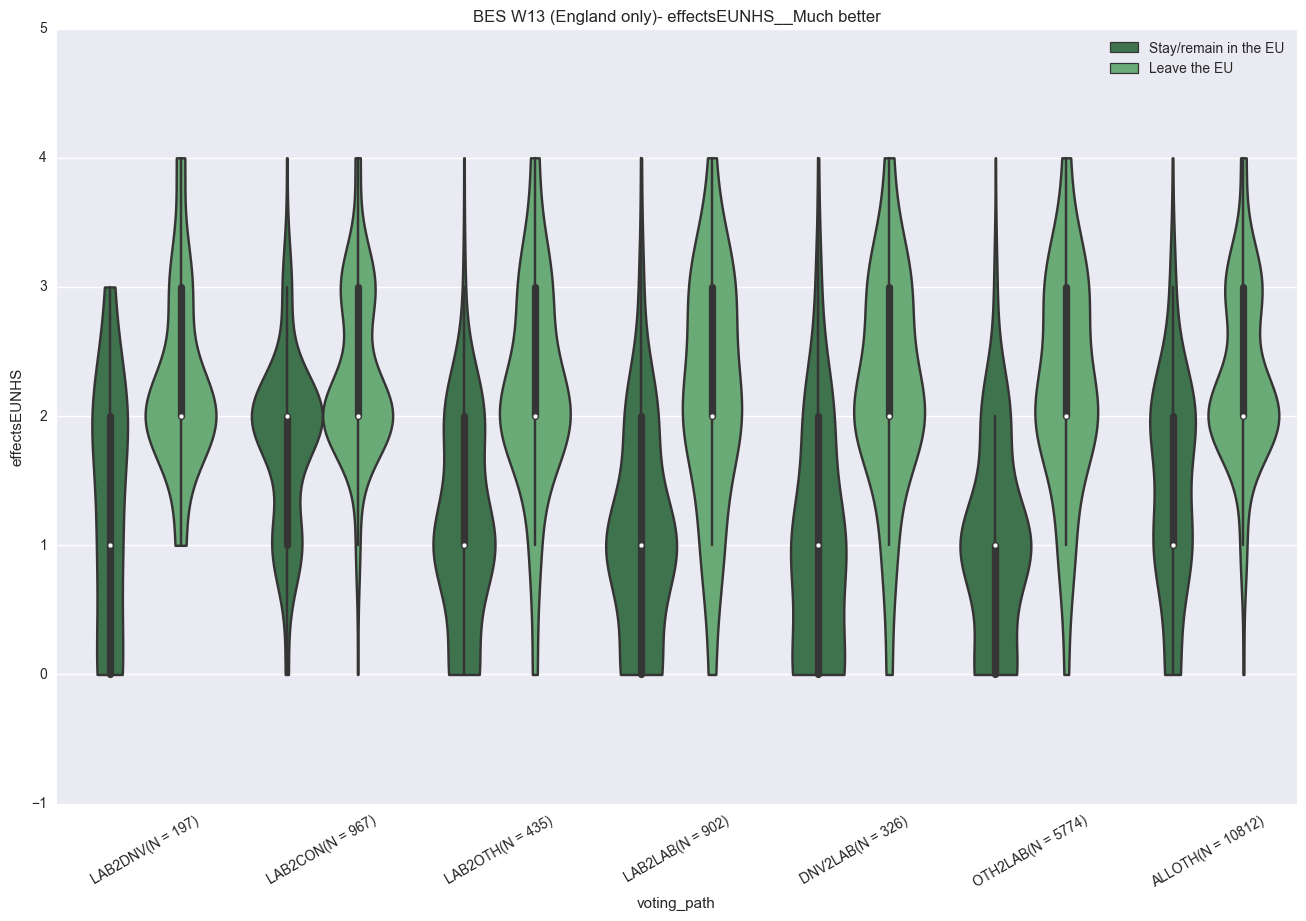

In [199]:

fig = plt.figure( figsize=(16,10) )
var = 'effectsEUNHS'
y= BES_numeric[var][England]
bw = .5
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



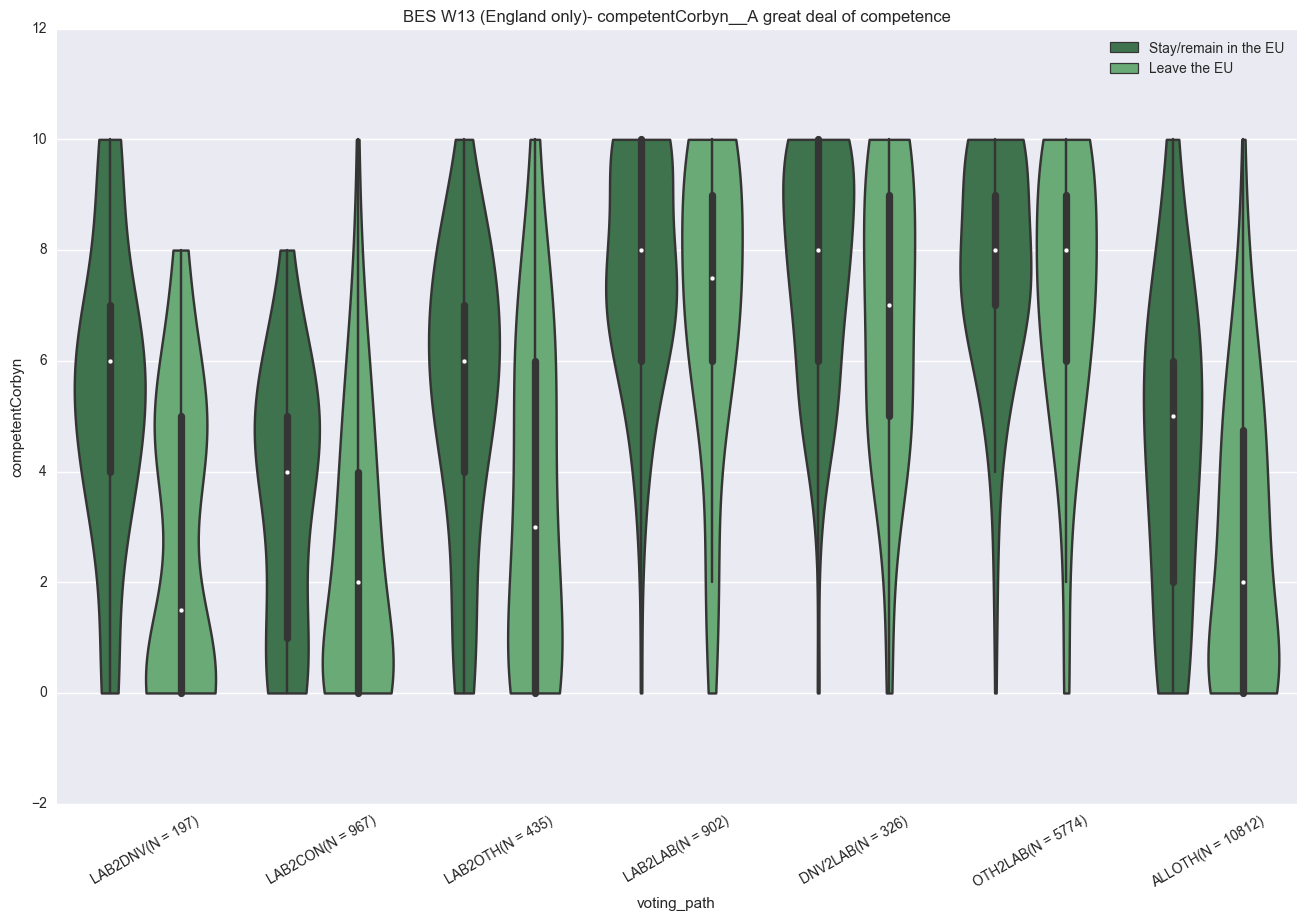

In [200]:

fig = plt.figure( figsize=(16,10) )
var = 'competentCorbyn'
y= BES_numeric[var][England]
bw = .5
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



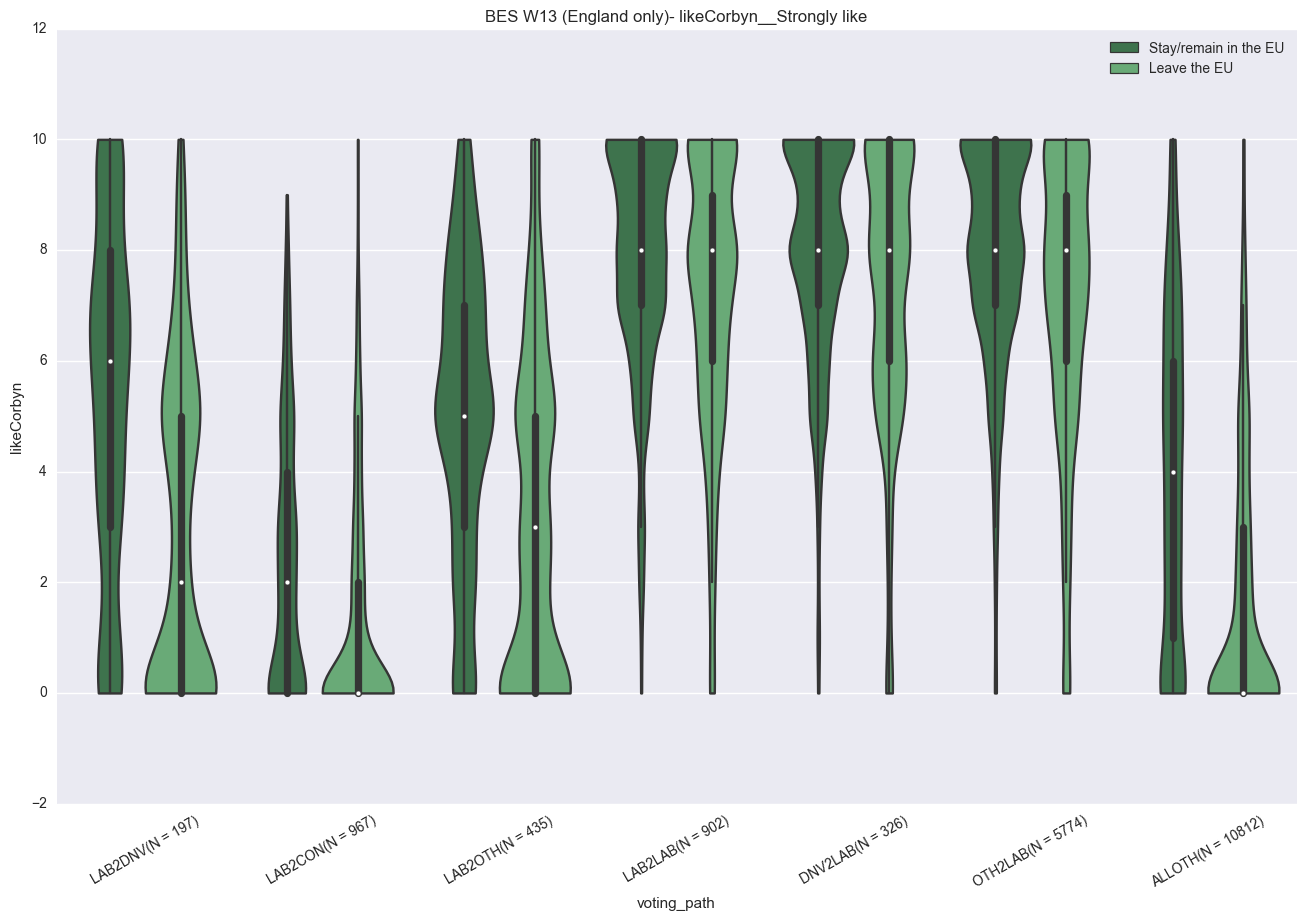

In [205]:

fig = plt.figure( figsize=(16,10) )
var = 'likeCorbyn'
y= BES_numeric[var][England]
bw = 2.5/BES_numeric[var][England].max()
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



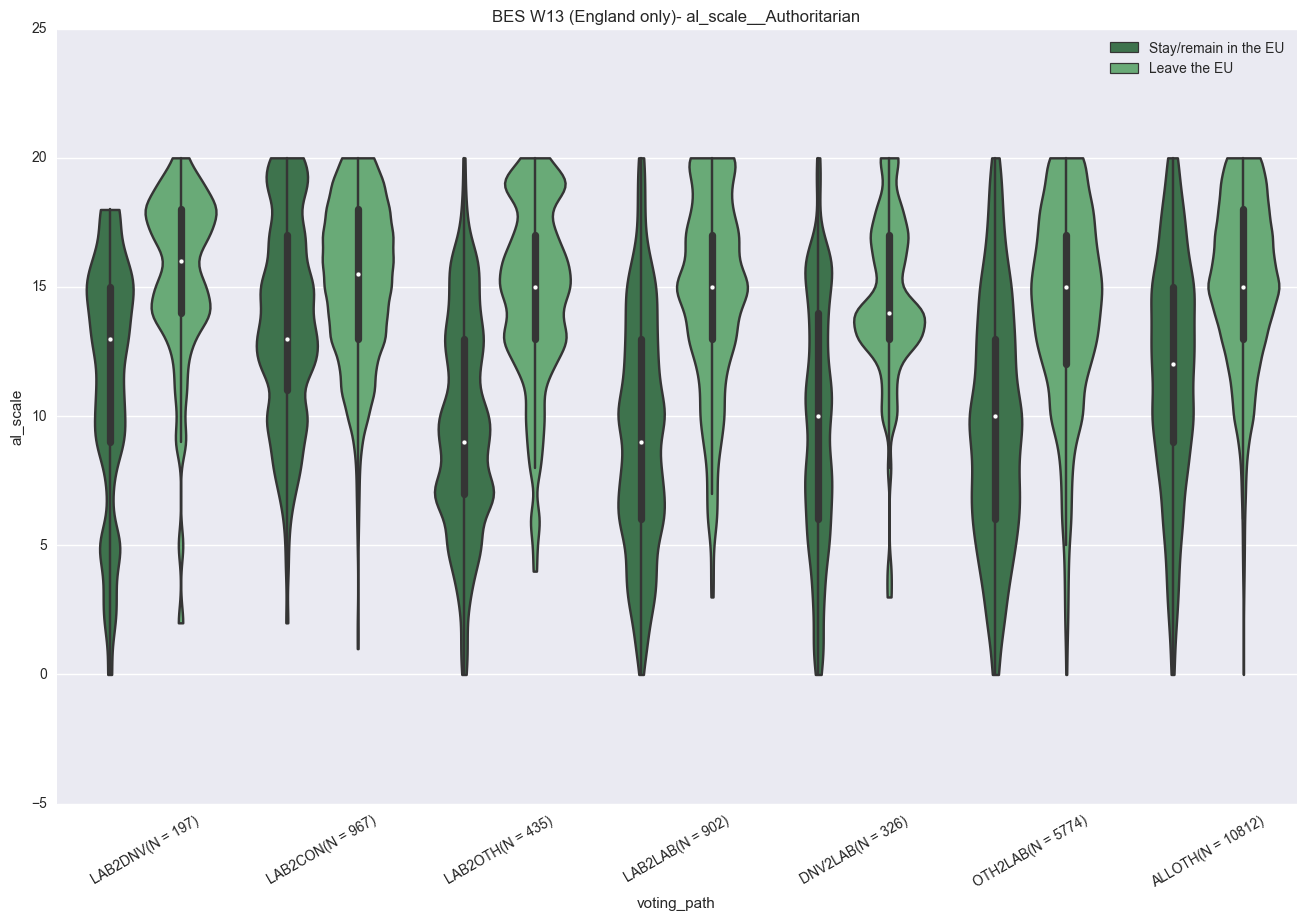

In [213]:

fig = plt.figure( figsize=(16,10) )
var = 'al_scale'
y= BES_numeric[var][England]
bw = 3.5/(BES_numeric[var][England].max())
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



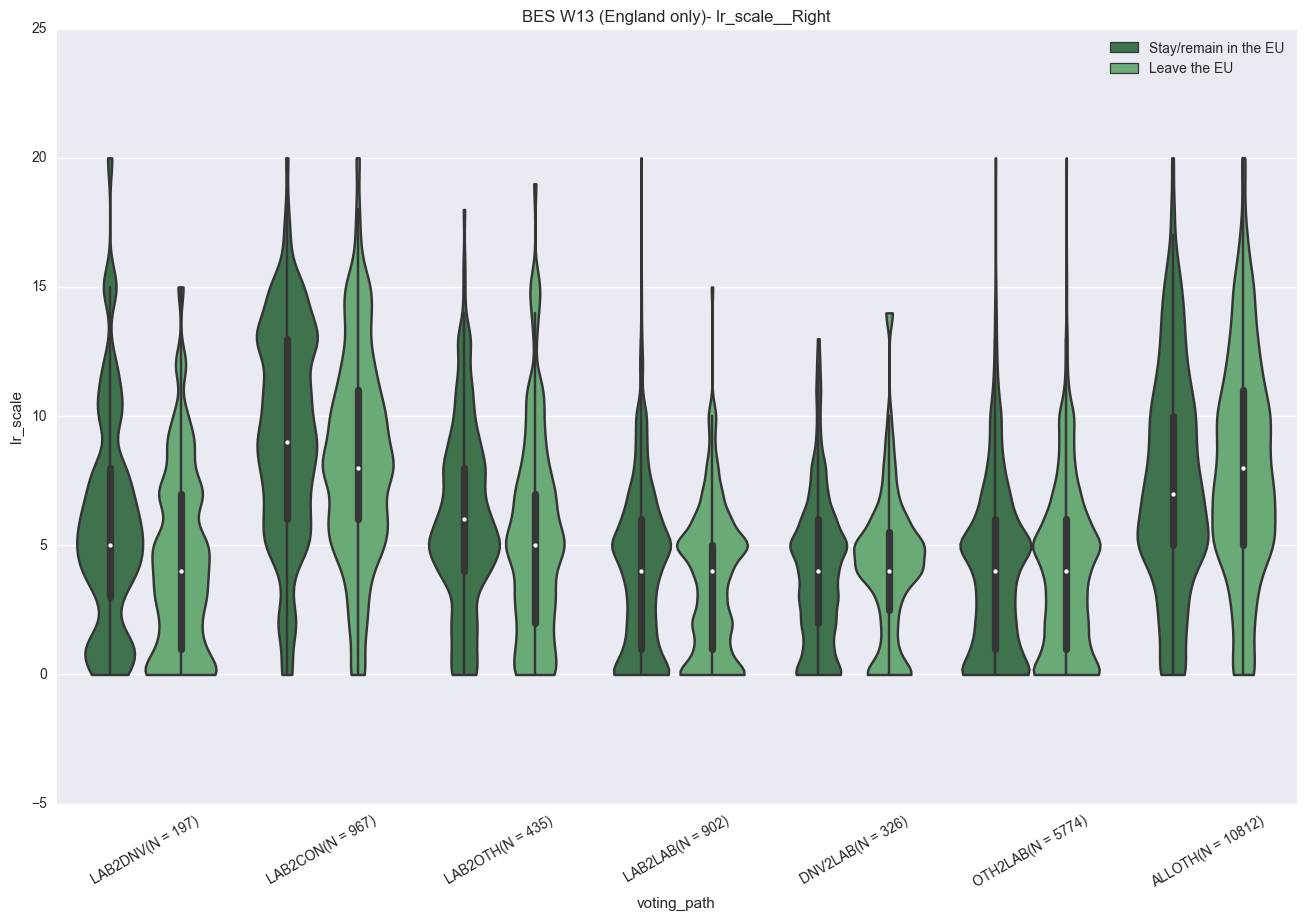

In [214]:

fig = plt.figure( figsize=(16,10) )
var = 'lr_scale'
y= BES_numeric[var][England]
bw = 3.5/(BES_numeric[var][England].max())
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



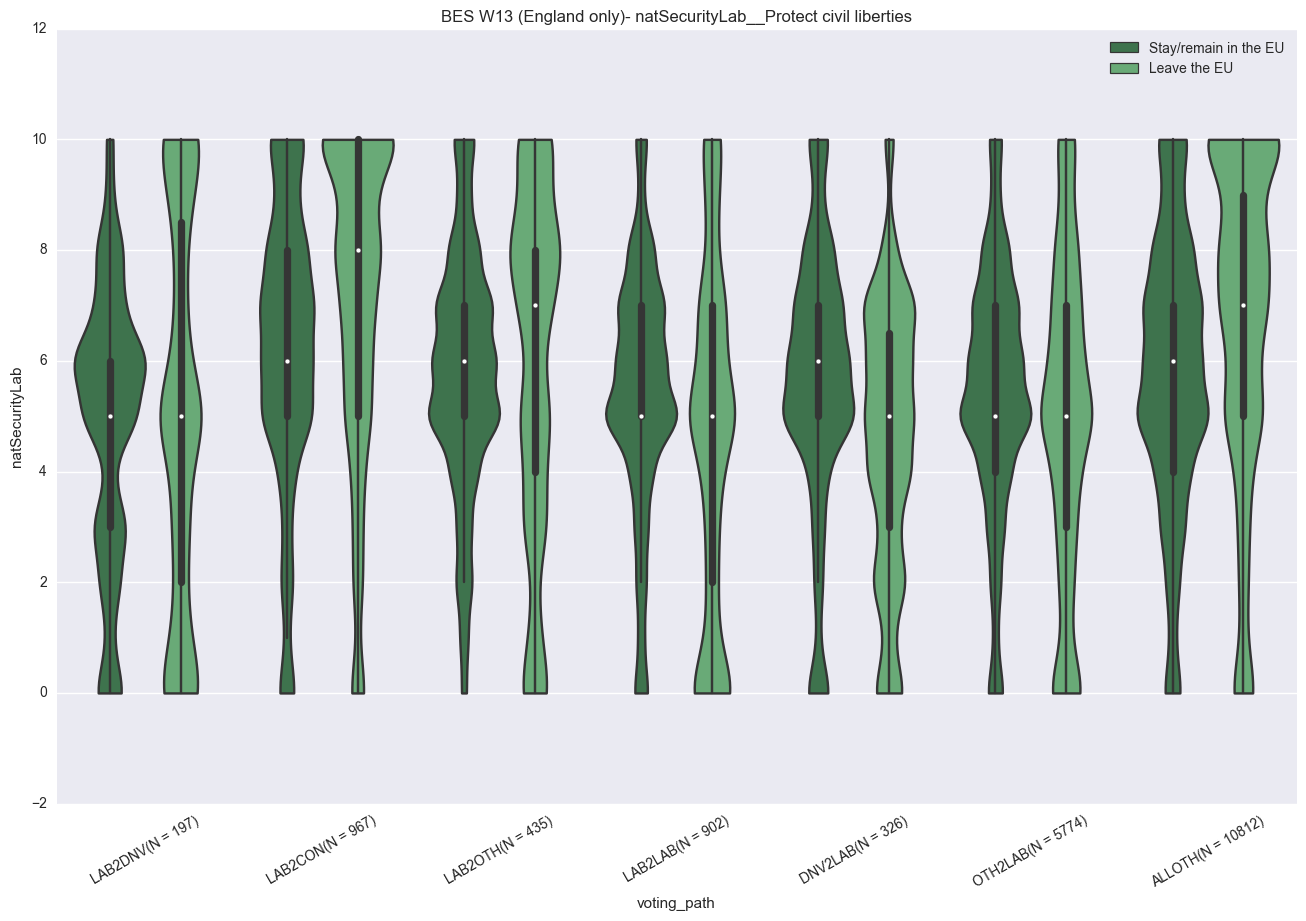

In [219]:
# parties are more likely to win elections when they stick to their principles
fig = plt.figure( figsize=(16,10) )
var = 'natSecurityLab'
y= BES_numeric[var][England]
bw = 2/(BES_numeric[var][England].max())
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



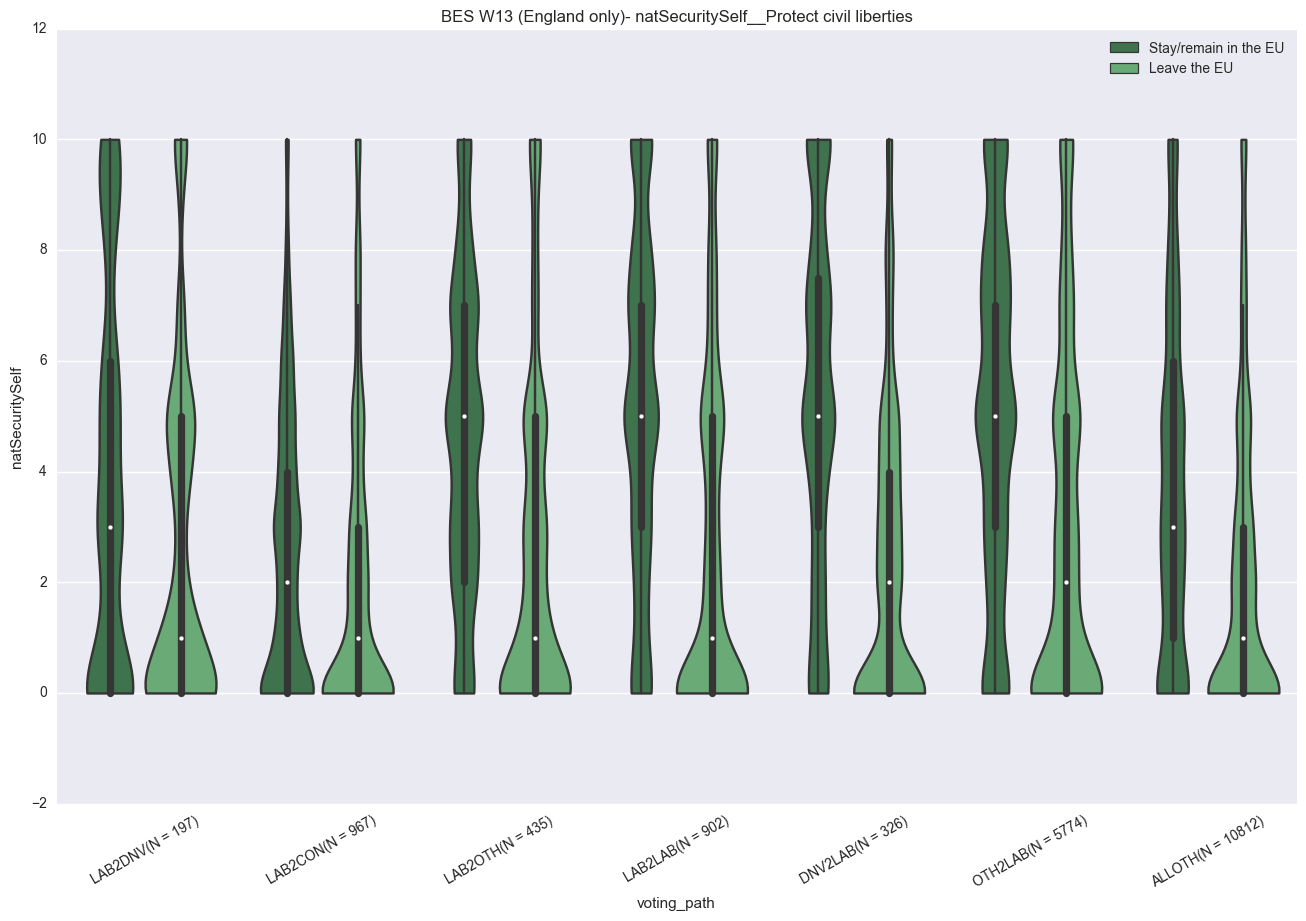

In [220]:
# parties are more likely to win elections when they stick to their principles
fig = plt.figure( figsize=(16,10) )
var = 'natSecuritySelf'
y= BES_numeric[var][England]
bw = 2/(BES_numeric[var][England].max())
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



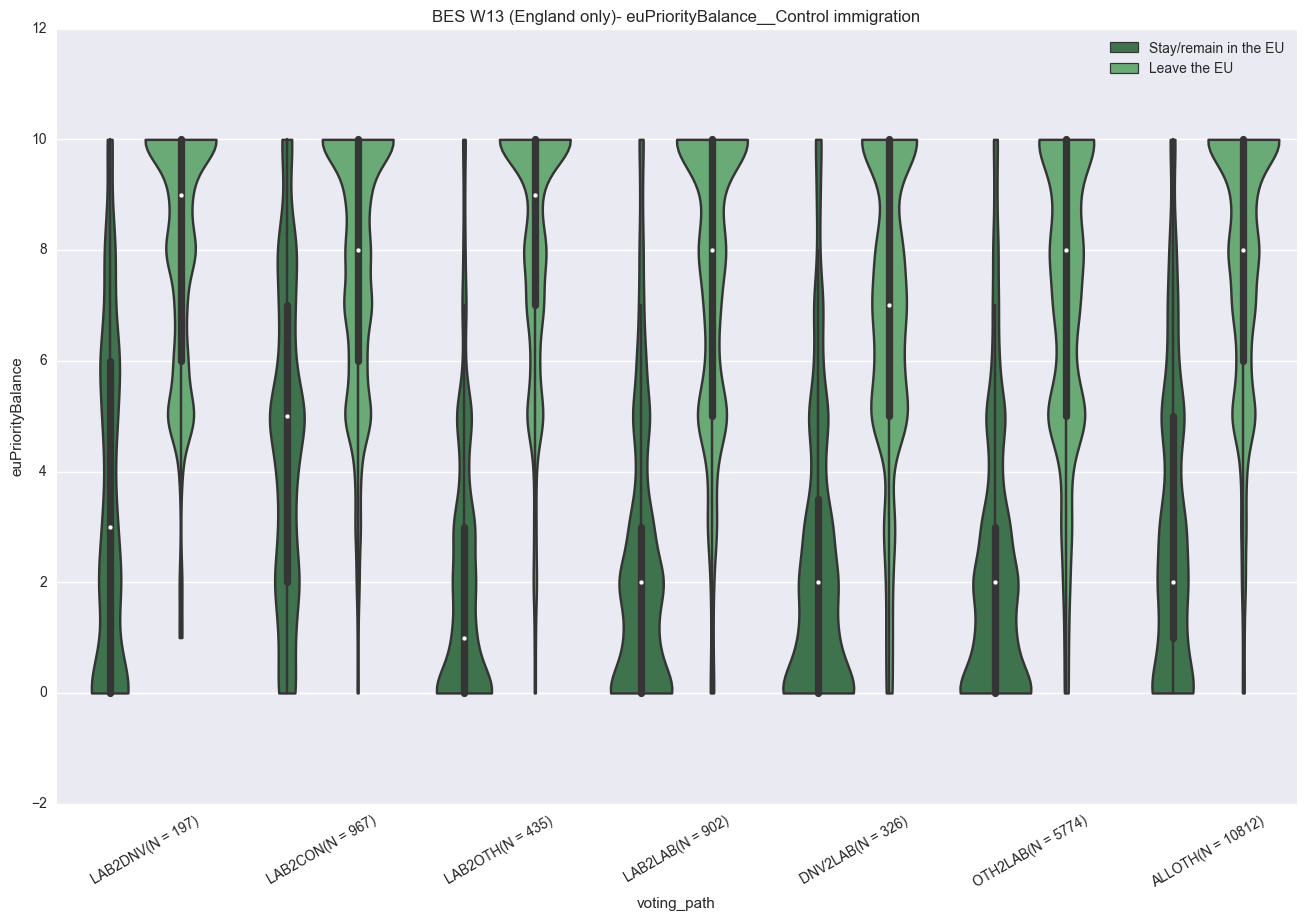

In [221]:
# parties are more likely to win elections when they stick to their principles
fig = plt.figure( figsize=(16,10) )
var = 'euPriorityBalance'
y= BES_numeric[var][England]
bw = 2/(BES_numeric[var][England].max())
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')



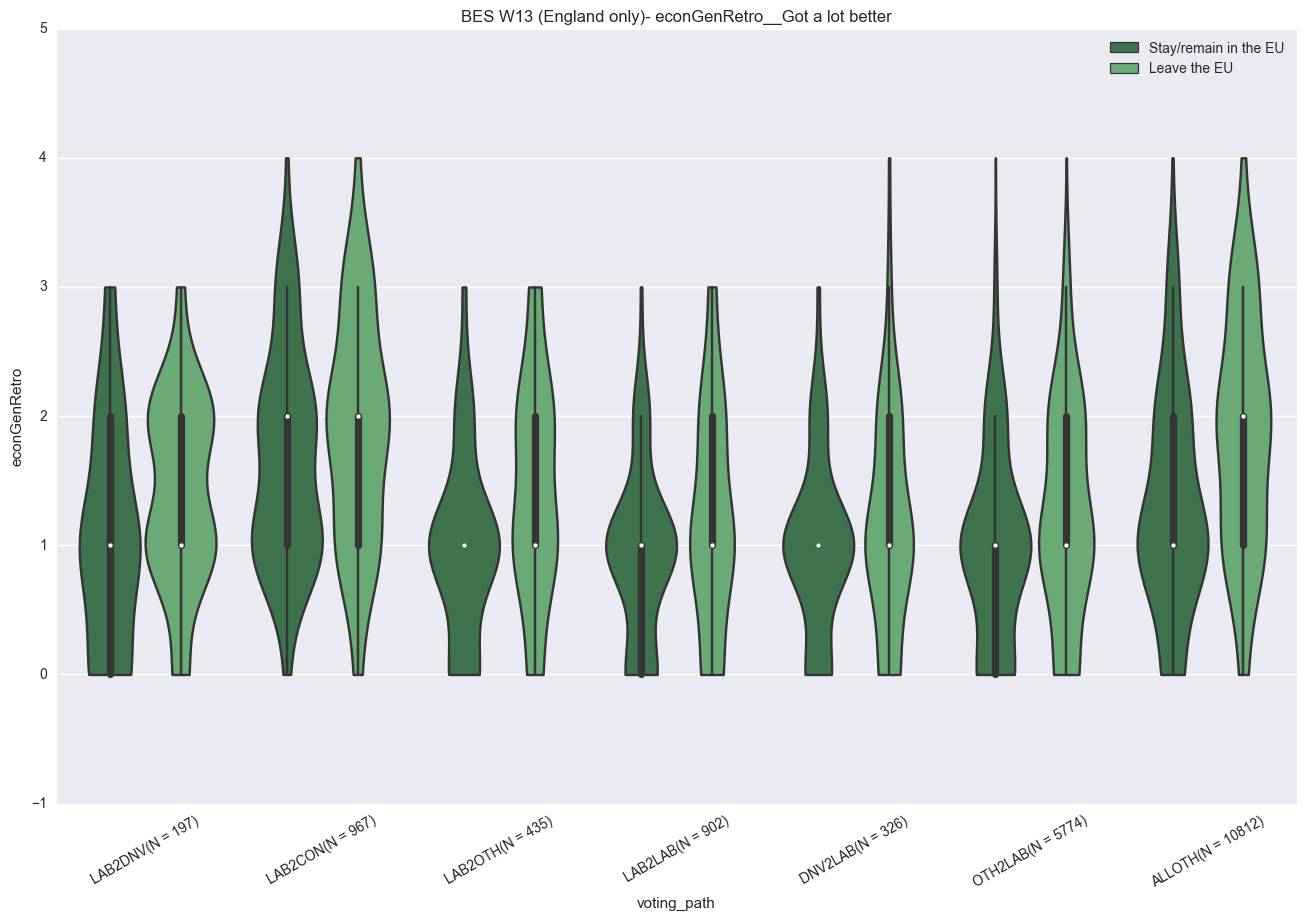

In [222]:
# parties are more likely to win elections when they stick to their principles
fig = plt.figure( figsize=(16,10) )
var = 'econGenRetro'
y= BES_numeric[var][England]
bw = 2/(BES_numeric[var][England].max())
eusplit = True
if eusplit:
    hue = BES_numeric["euRefVote"].astype('category').cat.rename_categories(cat_dictionary["euRefVote"])[England]
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0, hue= hue,
                       palette="Greens_d", order=order);
else:
    g = sns.categorical.violinplot(x=df["voting_path"][England], y=y, bw=bw, cut=0,
                       palette="Greens_d", order=order);    
g.set_xticklabels(labels = order, rotation=30);
title = "BES W13 (England only)- " + old_new_col_names[var]
g.set_title(title)
fig.savefig(BES_data_folder+title+'.png')

